# Notebook to create OF figures for manuscrip.

Imports

In [2]:
%matplotlib inline

from pathlib import Path
from types import SimpleNamespace
from joblib import delayed, Parallel
import time
import traceback

import numpy as np
import pandas as pd
import scipy.stats as stats
pd.set_option('display.max_rows', 50)

import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import seaborn as sns
sns.set(style='whitegrid', palette='muted')
from matplotlib_venn import venn2, venn3

## added TreeMazeanalyses folder using the following command
## conda develop /home/alexgonzalez/Documents/TreeMazeAnalyses2
import TreeMazeAnalyses2.Utils.robust_stats as rs

from TreeMazeAnalyses2.Analyses.subject_info import SubjectInfo, SubjectSessionInfo
from TreeMazeAnalyses2.Analyses import spatial_functions as spatial_funcs
import TreeMazeAnalyses2.Analyses.open_field_functions as of_funcs

from TreeMazeAnalyses2.Analyses import cluster_match_functions as cmf

from importlib import reload

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Defaults

In [51]:
subjects = ['Li', 'Ne', 'Cl', 'Al', 'Ca', 'Mi']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
analyses_colors = sns.color_palette(palette='deep', as_cmap=True)
type_color = {'hd': analyses_colors[0],
              'speed': analyses_colors[1],
              'border': analyses_colors[2],
              'grid': analyses_colors[3],
              'pos': analyses_colors[4]}

gd_results_path = Path("/home/alexgonzalez/google-drive/TreeMazeProject/Results_Summary/")
local_results_path = Path("/mnt/Data_HD2T/SummaryData/")

fig5_path = Path("/home/alexgonzalez/google-drive/TreeMazeProject/Figures/OF_Fig/")

units_table_fn = "all_units_table.csv"
metric_scores_fn = 'of_metric_scores_summary_table.csv'
model_scores_fn = 'of_model_scores_summary_table.csv'

Load data

In [127]:
metric_scores = pd.read_csv(local_results_path / metric_scores_fn, index_col=0)
model_scores = pd.read_csv(local_results_path / model_scores_fn, index_col=0)
unit_table = pd.read_csv(local_results_path / units_table_fn, index_col=0)

## correct scores tables for erronous session

In [128]:
invalid_sessions = ['Li_OF_080718'] ## mislabeled session

for session in invalid_sessions:
    unit_idx = unit_table[unit_table.session==session].unique_cl_name
    metric_scores.loc[metric_scores.cl_name.isin(unit_idx), 'session_valid'] = False
    model_scores.loc[model_scores.cl_name.isin(unit_idx), 'session_valid'] = False

In [946]:
metric_scores[(metric_scores.session=='Li_OF_070618') & (metric_scores.analysis_type=='grid')].head()

unit_id subject       session  session_pct_cov  session_valid  \
2874      564      Li  Li_OF_070618             0.97           True   
2875      565      Li  Li_OF_070618             0.97           True   
2876      566      Li  Li_OF_070618             0.97           True   
2877      567      Li  Li_OF_070618             0.97           True   
2878      568      Li  Li_OF_070618             0.97           True   

      session_unit_id unit_type  tt  tt_cl                      cl_name  \
2874                0      cell   8      0   Li_OF_070618-tt8_d17.5_cl0   
2875                1      cell   8      2   Li_OF_070618-tt8_d17.5_cl2   
2876                2      cell   9      5  Li_OF_070618-tt9_d20.25_cl5   
2877                3      cell  10      8  Li_OF_070618-tt10_d19.0_cl8   
2878                4      cell  14      8  Li_OF_070618-tt14_d18.0_cl8   

     analysis_type     score  sig  
2874          grid  0.130686  0.0  
2875          grid -0.033243  0.0  
2876          grid       NaN  0.0  
2877          grid       NaN  0.0  
2878          grid  0.214635  1.0

(array([ 15.,  79., 135.,  69.,  10.,   4.,   1.,   0.,   0.,   1.]),
 array([-0.36196997, -0.26000605, -0.15804213, -0.0560782 ,  0.04588572,
         0.14784964,  0.24981357,  0.35177749,  0.45374141,  0.55570534,
         0.65766926]),
 <a list of 10 Patch objects>)

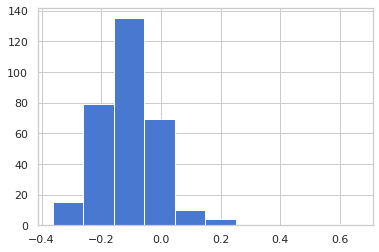

In [957]:
plt.hist(metric_scores[(metric_scores.analysis_type=='grid') & (metric_scores.unit_type=='cell') & (metric_scores.session_valid)].score)

In [130]:
model_scores[(model_scores.session=='Li_OF_070618') & (model_scores.model=='pos') & (model_scores.metric=='r2') ].head()

unit_id subject       session  session_unit_id unit_type  \
23142      564      Li  Li_OF_070618                0      cell   
23143      564      Li  Li_OF_070618                0      cell   
23150      565      Li  Li_OF_070618                1      cell   
23151      565      Li  Li_OF_070618                1      cell   
23158      566      Li  Li_OF_070618                2      cell   

       session_pct_cov  session_valid  tt  tt_cl model  split metric  \
23142             0.97           True   8      0   pos   test     r2   
23143             0.97           True   8      0   pos  train     r2   
23150             0.97           True   8      2   pos   test     r2   
23151             0.97           True   8      2   pos  train     r2   
23158             0.97           True   9      5   pos   test     r2   

          value                      cl_name  
23142  0.010733   Li_OF_070618-tt8_d17.5_cl0  
23143  0.083029   Li_OF_070618-tt8_d17.5_cl0  
23150 -0.005459   Li_OF_070618-tt8_d17.5_cl2  
23151  0.051122   Li_OF_070618-tt8_d17.5_cl2  
23158  0.012321  Li_OF_070618-tt9_d20.25_cl5

## select example cell

In [7]:
analyses=['speed','hd','border','grid', 'stability']
@interact(analysis_type=analyses, unit_type=['cell', 'mua', None], thr=widgets.FloatSlider(min=-1, max=1, step=0.02))
def metric_filter_units(analysis_type, thr, unit_type=None):
    if unit_type is None:
        sub_table = metric_scores.loc[ (metric_scores.analysis_type==analysis_type) 
                                      & (metric_scores.score>=thr) 
                                      & (metric_scores.session_valid)]
    else:
        sub_table = metric_scores.loc[ (metric_scores.unit_type==unit_type) 
                                      & (metric_scores.analysis_type==analysis_type) 
                                      & (metric_scores.score>=thr)
                                      & (metric_scores.session_valid)]
    return sub_table.sort_values(by=['score'], ascending=False)
        

interactive(children=(Dropdown(description='analysis_type', options=('speed', 'hd', 'border', 'grid', 'stabili…

In [132]:
@interact(model=['speed','hd','border','grid', 'pos'], thr=widgets.FloatSlider(min=-1, max=1, step=0.02), unit_type=['cell', 'mua', None], model_metric=['r2', 'map_r', 'n_err', 'coef'], split=['train', 'test'] )
def model_filter_units(model, thr, model_metric, split, unit_type=None):
    if unit_type is None:
        sub_table = model_scores.loc[ (model_scores.model==model)
                                      & (model_scores.metric==model_metric)
                                      & (model_scores.split==split) 
                                      & (model_scores.value>=thr) 
                                      & (model_scores.session_valid)]
    else:
        sub_table = model_scores.loc[ (model_scores.unit_type==unit_type) 
                                      & (model_scores.model==model)
                                      & (model_scores.metric==model_metric)
                                      & (model_scores.split==split) 
                                      & (model_scores.value>=thr) 
                                      & (model_scores.session_valid)]

    return sub_table.sort_values(by=['value'], ascending=False)


interactive(children=(Dropdown(description='model', options=('speed', 'hd', 'border', 'grid', 'pos'), value='s…

Helper functions

In [1199]:
label_fontsize = 14

def get_bin_ang_fr(track_data, fr, bin_step= np.pi/18, min_speed=3):
    hd = track_data['hd']
    sp = track_data['sp']
    
    speed_valid_idx = sp>=min_speed 
    hd2 = hd[speed_valid_idx]
    fr2 = fr[speed_valid_idx]
    
    res, ang_fr, ang_bin_centers, ang_bin_edges = spatial_funcs.get_angle_stats(hd2, bin_step, weights=fr2)
    res['vec_len'] = np.abs(np.mean(ang_fr*np.exp(ang_bin_centers*1j)))
    res['ang_fr'] = ang_fr
    res['ang_bin_centers'] = ang_bin_centers
    res['ang_bin_edges'] = ang_bin_edges
    return res

def get_bin_sp_fr(track_data, fr, bin_step=3, min_speed=0, max_speed=80):
    sp = track_data['sp']
    
    sp_bin_edges = np.arange(min_speed,max_speed, bin_step)
    sp_design_mat, sp_bin_idx, valid_samps = spatial_funcs.get_speed_encoding_features(sp, sp_bin_edges)
    sp_bin_centers = sp_bin_edges[:-1] + bin_step/2
    
    fr2 = fr[valid_samps]
    
    n_bins = len(sp_bin_centers)
    sp_fr_m = np.zeros(n_bins)
    sp_fr_s = np.zeros(n_bins)
    for sp_idx in range(n_bins): 
        sp_fr_m[sp_idx] = np.nanmean(fr2[sp_design_mat[:,sp_idx]==1])
        sp_fr_s[sp_idx] = stats.sem(fr2[sp_design_mat[:,sp_idx]==1])
        
    r = stats.spearmanr(sp_fr_m, sp_bin_centers)
    res = {'r':r[0], 'p_val': r[1], 'sp_fr_m': sp_fr_m, 'sp_fr_s': sp_fr_s, 'sp_bin_centers':sp_bin_centers, 'sp_bin_edges': sp_bin_edges}
    
    return res

def colorline(
    x, y, z=None, colors=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0,ax=None):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    if colors is None:
        lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha,zorder=1)
    else:
        lc = mcoll.LineCollection(segments, colors=colors,
                              linewidth=linewidth, alpha=alpha,zorder=1)
    if ax is None:
        ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def getColBar(ax, values, cmap='magma', cax_pos=[0.85,0,0.05,0.2]):

    pos = ax.get_position()
    cax = ax.figure.add_axes([pos.x0+pos.width*cax_pos[0],pos.y0+cax_pos[1],pos.width*cax_pos[2],pos.height*cax_pos[3]])
    
    cMap=mpl.colors.ListedColormap(sns.color_palette(cmap,50))
    vmax = np.around(values.max(),1)
    vmin = np.around(values.min(),1)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cMap)

    mapper.set_array([])
    cbar = plt.colorbar(mapper,ticks=[vmin,vmax],cax=cax)
    cax.yaxis.set_tick_params(right=False)
    #cax.set_frame_on(False)
    for pos in ['right', 'top', 'bottom', 'left']:
        cax.spines[pos].set_visible(False)
    cbar.outline.set_color("None")

    cax.axes.tick_params(pad=-3)

    return cax
    
def plot_sp_fr(sp_bins, sp_fr_m, sp_fr_s, ax, set_title=True):
    ax.plot(sp_bins,sp_fr_m,linewidth=3)
    ax.fill_between(sp_bins, sp_fr_m - sp_fr_s, sp_fr_m + sp_fr_s, alpha=0.5)
    ax.set_xlabel(' Speed [cm/s]')
    ax.set_ylabel(' FR [sp/s]')
    ax.set_ylim([np.nanmin(sp_fr_m-sp_fr_s)*0.9, np.nanmax(sp_fr_m+sp_fr_s)*1.1])
    ax.set_xlim([0,81])
    if set_title:
        ax.set_title('Speed Tunning', fontsize=label_fontsize)
    return ax
    
def plot_ang_fr(ang_bins,ang_fr, mean_ang, vec_len ,ax, cmap='magma_r', set_title=True):
    colors = plt.cm.get_cmap(cmap)(ang_fr/ang_fr.max())

    ax.scatter(ang_bins,ang_fr,color=colors,zorder=2)
    colorline( np.append(ang_bins,ang_bins[0]) ,np.append(ang_fr,ang_fr[0]),colors=np.append(colors,[colors[0]],axis=0),ax=ax)

    ax.plot([0,mean_ang],[0,vec_len],color='k',linewidth=4, solid_capstyle='round')
    ax.set_xticklabels(['E','','','','W'], fontsize=label_fontsize)

    ax.set_yticks([])
    ax.set_ylim([0,np.max(ang_fr)*1.1])
    if set_title:
        ax.set_title('HD Tunning', fontsize=label_fontsize)

    cax=getColBar(ax, ang_fr, cmap=cmap, cax_pos=[0.95,0,0.05,0.2])
    cax.set_ylabel(' fr', rotation='horizontal', va='center', ha='right', fontsize=label_fontsize)

    return ax, cax

def plot_xy_spks(x,y,spikes,ax, set_title=True):
    ax.plot(x,y,linewidth=1,color='k',alpha=0.5)
    ax.scatter(x,y,s=spikes*3,color='r',alpha=0.7)
    ax.set_aspect('equal',adjustable='box')
    ax.set_axis_off()
    if set_title:
        ax.set_title('Traces + Spikes', fontsize=label_fontsize)
    return ax

def plot_fr_map(fr_map, ax, cmap='viridis', set_title=True):
    vmin=0 
    vmax = fr_map.max()
    colors = plt.cm.get_cmap(cmap)(fr_map/vmax)

    ax = sns.heatmap(fr_map, xticklabels=[], yticklabels=[], cmap=cmap, 
                     vmin=0, vmax=vmax, square=True, cbar=False, ax=ax)

    ax.invert_yaxis()
    if set_title:
        ax.set_title('FR Map', fontsize=label_fontsize)

    cax = getColBar(ax, fr_map.flatten(), cmap=cmap, cax_pos=[1.02,0,0.05,0.2])
    cax.set_ylabel(' fr', rotation='horizontal', va='center', ha='right', fontsize=label_fontsize)

    return ax, cax

def plot_fr_map2(track_data, spikes, fr, fr_map, cl_name=None, ax=None, cbar=False, max_txt=True, cmap='viridis'):
    if ax is None:
        f,ax = plt.subplots(figsize=(4,4))
    else:
        f = ax.figure
    
    vmin, vmax = 0, fr_map.max()
    colors = plt.cm.get_cmap(cmap)(fr_map/vmax)

    ax = sns.heatmap(fr_map, xticklabels=[], yticklabels=[], cmap=cmap, 
                     vmin=0, vmax=vmax, square=True, cbar=False, ax=ax)

    ax.invert_yaxis()
    #ax.set_title('FR Map', fontsize=label_fontsize)

    if cbar:
        cax = getColBar(ax, fr_map.flatten(), cmap=cmap, cax_pos=[1.02,0,0.05,0.2])
        cax.set_ylabel(' fr', rotation='horizontal', va='center', ha='right', fontsize=label_fontsize)

    if cl_name is not None:
        pos = ax.get_position()
        axt = f.add_axes([pos.x0-0.1,pos.y0,0.02,pos.height])
        axt.text(0,.1, cl_name, rotation=90)
        axt.set_axis_off()
        
    if max_txt:
        pos = ax.get_position()
        axt = f.add_axes([pos.x0+pos.width+0.01, pos.y0, 0.02,0.1])
        axt.text(0,.1, np.around(vmax,1), fontsize=8)
        axt.set_axis_off()
        
    return f, ax

def plot_OF(cl_name, track_data, spikes, fr, fr_map, figsize=None):
    
    label_fontsize = 14
    
    if figsize is None:
        f = plt.figure(constrained_layout=True, figsize=(10 , 5))
    else:
        f = plt.figure(constrained_layout=True, figsize=figsize)
        
    gs = f.add_gridspec(2,3)
    ax = [[]]*4
    ax[0] = f.add_subplot(gs[:, 0])
    ax[1] = f.add_subplot(gs[:, 1])
    ax[2] = f.add_subplot(gs[0, 2], projection='polar')
    ax[3] = f.add_subplot(gs[1, 2])

    x,y = track_data['x'],track_data['y']
    ax[0] = plot_xy_spks(x,y,spikes,ax[0])
    
    ax[1], cax = plot_fr_map(fr_map, ax[1])
     
    res = get_bin_ang_fr(track_data, fr)
    vec_len, mean_ang, ang_fr, ang_bin_centers = res['vec_len'], res['mean_ang'], res['ang_fr'], res['ang_bin_centers']
    ax[2], cax = plot_ang_fr(ang_bin_centers, ang_fr, mean_ang, vec_len,  ax[2])
    
    res = get_bin_sp_fr(track_data, fr)
    sp_bin_centers, sp_fr_m, sp_fr_s = res['sp_bin_centers'], res['sp_fr_m'], res['sp_fr_s']
    ax[3] = plot_sp_fr(sp_bin_centers, sp_fr_m, sp_fr_s, ax[3])

    ap = ax[2].get_position()
    pos = [ap.x0+0.03, ap.y0, ap.width*0.8, ap.height*0.75]
    ax[2].set_position(pos)
    
    ap = ax[3].get_position()
    pos = [ap.x0+0.1, ap.y0+0.1, ap.width*0.55, ap.height*0.65]
    ax[3].set_position(pos)
    
    axt = f.add_axes([0,0,0.02,1])
    axt.text(-0.2,.25, cl_name, rotation=90)
    axt.set_axis_off()
    return f, ax

def plot_OF2(cl_name, track_data, spikes, fr, fr_map):
    
    label_fontsize = 14
    
    f = plt.figure(figsize=(8,6))
    gs = f.add_gridspec(2,2)
    ax = [[]]*4
    ax[0] = f.add_subplot(gs[:, 0])
    ax[1] = f.add_subplot(gs[0, 1], projection='polar', position=[0.55, 0.55, 0.2, 0.2])
    ax[2] = f.add_subplot(gs[1, 1], position=[0.58, 0.28, 0.15, 0.2])
    
    x,y = track_data['x'],track_data['y']
    ax[0] = plot_xy_spks(x,y,spikes,ax[0])
  
    res = get_bin_ang_fr(track_data, fr)
    vec_len, mean_ang, ang_fr, ang_bin_centers = res['vec_len'], res['mean_ang'], res['ang_fr'], res['ang_bin_centers']
    ax[1], cax =plot_ang_fr(ang_bin_centers, ang_fr, mean_ang, vec_len,  ax[1])

    res = get_bin_sp_fr(track_data, fr)
    sp_bin_centers, sp_fr_m, sp_fr_s = res['sp_bin_centers'], res['sp_fr_m'], res['sp_fr_s']
    ax[2]=plot_sp_fr(sp_bin_centers, sp_fr_m, sp_fr_s, ax[2])
    
    pos = ax[0].get_position()
    axt = f.add_axes([pos.x0-0.03,pos.y0,0.02,pos.height])
#     axt = f.add_axes([0.1,0,0.02,1])
    axt.text(0,.1, cl_name, rotation=90)
    axt.set_axis_off()
    
    return f, ax

def load_cell(idx, table):
    subject, session, session_unit_id = table.loc[idx]['subject'], table.loc[idx]['session'], table.loc[idx]['session_unit_id']
    session_info = SubjectSessionInfo(subject, session)
    
    track_data = session_info.get_track_data()
    spikes = session_info.get_binned_spikes()[session_unit_id]
    fr = session_info.get_fr()[session_unit_id]
    fr_map = session_info.get_fr_maps()[session_unit_id]

    return track_data, spikes, fr, fr_map
#f,ax = plot_OF(track_data, spikes, fr, fr_maps)

In [1200]:
analysis_type = 'grid'
thr = 0.2
sub_metric_table = metric_filter_units(analysis_type=analysis_type, thr=thr)

@interact(idx=sub_metric_table.index)
def plot_OF_unit(idx):

    cl_name = metric_scores.loc[idx, 'cl_name']
    f,ax = plot_OF(cl_name, *load_cell(idx, metric_scores) )
    return metric_scores[metric_scores.cl_name==cl_name]

interactive(children=(Dropdown(description='idx', options=(2879, 4476, 2788, 10839, 9473, 3139, 3010, 9690, 37…

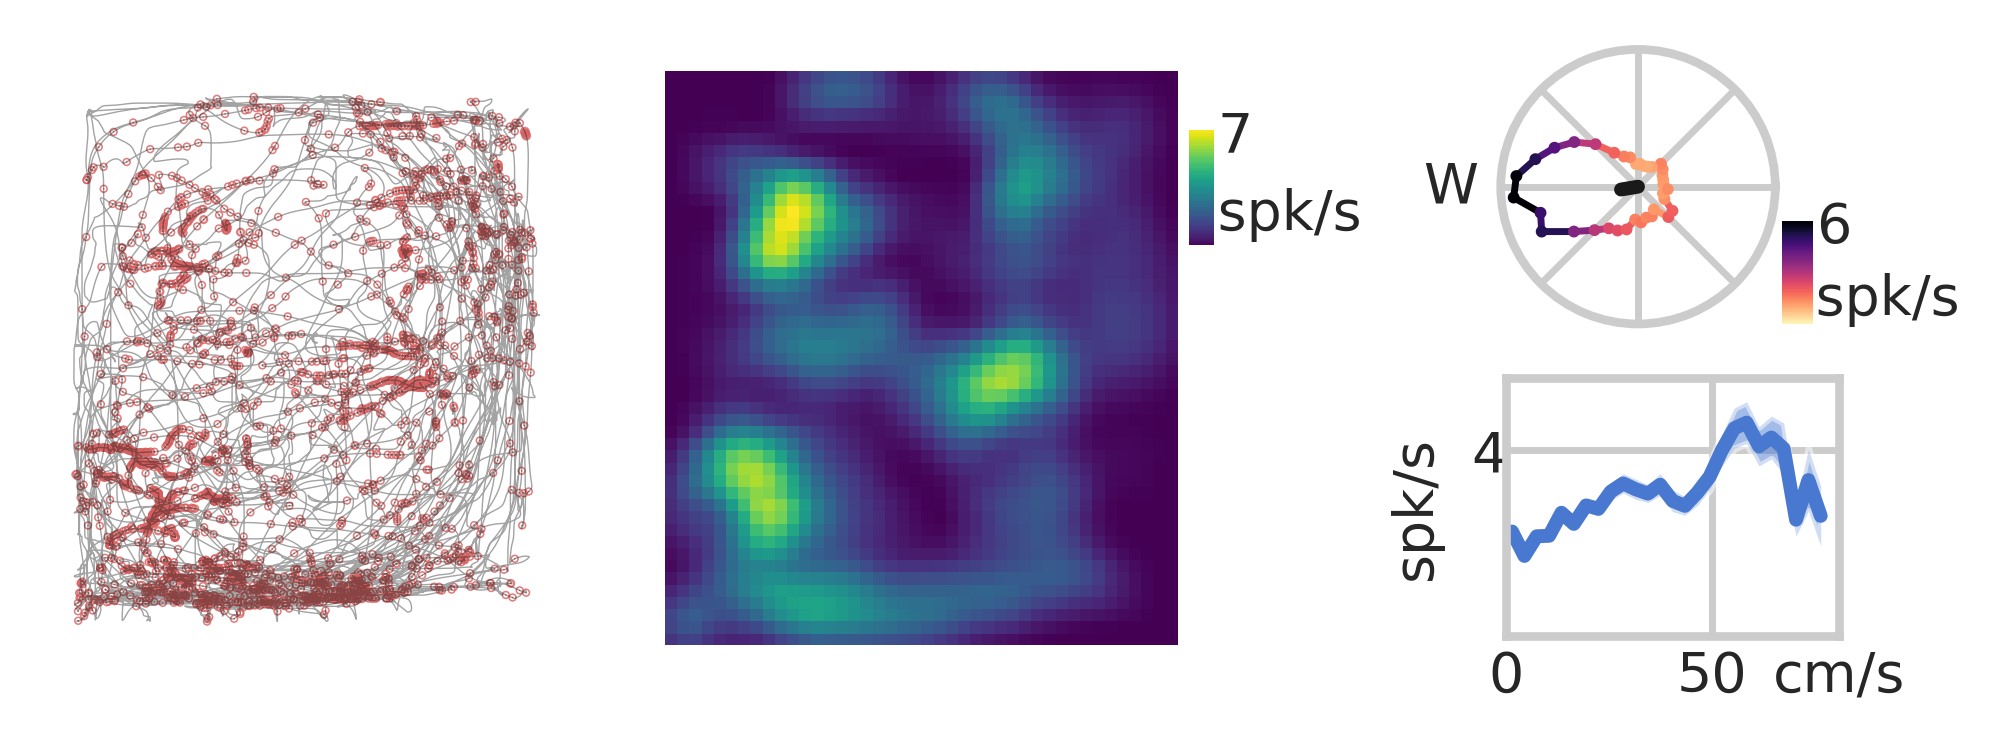

In [1313]:

def plot_OF_example_unit_final(cl_name, track_data, spikes, fr, fr_map, figsize=None):
    
    
    dpi = 500
    label_fontsize = 10
    tick_fontsize=8
    def plot_xy_spks(x,y,spikes,ax):
        ax.plot(x,y,linewidth=0.2,color='k',alpha=0.4)
        xs = x[spikes>0]
        ys = y[spikes>0]
        ss = spikes[spikes>0]
        ax.scatter(xs,ys,s=ss*0.05, color='r', edgecolors=None, alpha=0.8)
        ax.set_aspect('equal',adjustable='box')
        ax.set_axis_off()
        return ax

    def plot_fr_map(fr_map, ax, cmap='viridis'):
        vmin=0 
        vmax = fr_map.max()
        colors = plt.cm.get_cmap(cmap)(fr_map/vmax)

        ax = sns.heatmap(fr_map, xticklabels=[], yticklabels=[], cmap=cmap, 
                         vmin=0, vmax=vmax, square=True, cbar=False, ax=ax)

        ax.invert_yaxis()
        cax = getColBar(ax, fr_map.flatten(), cmap=cmap, cax_pos=[1.02,0,0.05,0.2])
        cax.set_yticklabels(['',int(vmax)], fontsize=tick_fontsize, ha='center')
        cax.set_ylabel(' spk/s', rotation='horizontal', va='top', fontsize=tick_fontsize)
        return ax, cax

    def plot_ang_fr(ang_bins,ang_fr, mean_ang, vec_len ,ax, cmap='magma_r', set_title=True):
        colors = plt.cm.get_cmap(cmap)(ang_fr/ang_fr.max())

        ax.scatter(ang_bins,ang_fr,s=0.5,color=colors,zorder=2)
        colorline( np.append(ang_bins,ang_bins[0]) ,np.append(ang_fr,ang_fr[0]),colors=np.append(colors,[colors[0]],axis=0), 
                  linewidth=1, ax=ax)

        ax.plot([0,mean_ang],[0,vec_len],color='k',linewidth=2, solid_capstyle='round')
        #ax.set_xticklabels(['','','','','W'], fontsize=tick_fontsize, ha='left')    
        ax.set_xticklabels([])
        
        vmax=np.max(ang_fr)
        ax.set_yticks([])
        ax.set_ylim([0,vmax*1.1])
        ax.text(np.pi, ang_fr.max()*1.5, 'W', fontsize=tick_fontsize, ha='center', va='center')
        if set_title:
            ax.set_title('HD Tunning', fontsize=label_fontsize)

        cax=getColBar(ax, ang_fr, cmap=cmap, cax_pos=[0.95,0,0.05,0.2])
        cax.set_yticklabels(['',int(vmax)], fontsize=tick_fontsize, ha='center')
        cax.set_ylabel(' spk/s', rotation='horizontal', va='top', fontsize=tick_fontsize)

        return ax, cax

    def plot_sp_fr(sp_bins, sp_fr_m, sp_fr_s, ax, set_title=True):
        
        ax.plot(sp_bins,sp_fr_m,linewidth=2)
        ax.fill_between(sp_bins, sp_fr_m - sp_fr_s, sp_fr_m + sp_fr_s, alpha=0.5)
        #ax.set_xlabel(' Speed [cm/s]')
        ax.set_ylim([np.nanmin(sp_fr_m-sp_fr_s)*0.9, np.nanmax(sp_fr_m+sp_fr_s)*1.1])
        
        #ax.yaxis.tick_right()
        vmax = np.max(sp_fr_m).astype(int)
        ax.set_yticks([0, vmax])
        ax.set_yticklabels(['', vmax], fontsize=tick_fontsize)
        ax.yaxis.set_tick_params(right=False) 
        yticklabels=ax.get_yticklabels() 
        for l in yticklabels:
            pos = l.get_position()
            l.set_position((pos[0]+0.2, pos[1]+0.2))
        ax.set_yticklabels(yticklabels)
        ax.set_ylabel("spk/s", fontsize=tick_fontsize)
        
        ax.set_xlim([0,81])
        ax.set_xticks([0, 50, 81])
        ax.set_xticklabels(['0', '50', 'cm/s'], fontsize=tick_fontsize, va='center')
        xticklabels=ax.get_xticklabels() 
        for l in xticklabels:
            pos = l.get_position()
            l.set_position((pos[0], pos[1]+0.1))
        ax.set_xticklabels(xticklabels)
        if set_title:
            ax.set_title('Speed Tunning', fontsize=tick_fontsize)
        return ax
    
    if figsize is None:
        f = plt.figure(constrained_layout=False, figsize=(4.5 , 2), dpi=dpi)
    else:
        f = plt.figure(constrained_layout=True, figsize=figsize)
        
    gs = f.add_gridspec(2,3)
    ax = [[]]*4
    ax[0] = f.add_subplot(gs[:, 0])
    ax[1] = f.add_subplot(gs[:, 1])
    ax[2] = f.add_subplot(gs[0, 2], projection='polar')
    ax[3] = f.add_subplot(gs[1, 2])

    x,y = track_data['x'],track_data['y']
    ax[0] = plot_xy_spks(x,y,spikes,ax[0])
    
    ax[1], cax = plot_fr_map(fr_map, ax[1])
    ap = cax.get_position()
    pos =[ap.x0,ap.y0+0.4, ap.width, ap.height]
    cax.set_position(pos)
     
    res = get_bin_ang_fr(track_data, fr)
    vec_len, mean_ang, ang_fr, ang_bin_centers = res['vec_len'], res['mean_ang'], res['ang_fr'], res['ang_bin_centers']
    ax[2], cax = plot_ang_fr(ang_bin_centers, ang_fr, mean_ang, vec_len,  ax[2], set_title=False)
    ap = cax.get_position()
    pos =[ap.x0+0.04,ap.y0, ap.width*1.8, ap.height*1.5]
    cax.set_position(pos)
    ap = ax[2].get_position()
    pos = [ap.x0+0.06, ap.y0, ap.width*0.8, ap.height*0.8]
    ax[2].set_position(pos)
    
    
    res = get_bin_sp_fr(track_data, fr)
    sp_bin_centers, sp_fr_m, sp_fr_s = res['sp_bin_centers'], res['sp_fr_m'], res['sp_fr_s']
    ax[3] = plot_sp_fr(sp_bin_centers, sp_fr_m, sp_fr_s, ax[3], set_title=False)

    
    ap = ax[3].get_position()
    pos = [ap.x0+0.1, ap.y0+0.1, ap.width*0.65, ap.height*0.75]
    ax[3].set_position(pos)
    
#     titles = ['Spike Traces', 'Rate Map', 'HD & Sp. Tunning']
#     for ii, t in enumerate(titles):
#         ax[ii].set_title(t, fontsize=label_fontsize)
    
#     axt = f.add_axes([0,0,0.02,1])
#     axt.text(-0.2,.25, cl_name, rotation=90)
#     axt.set_axis_off()
    return f, ax

idx = 2879
sns.set_style("whitegrid")
cl_name = metric_scores.loc[idx, 'cl_name']
f,ax = plot_OF_example_unit_final(cl_name, *load_cell(idx, metric_scores))
#ax[0].set_rasterized(True)
#ax[1].set_rasterized(True)

f.savefig(fig5_path / f'OF_Metrics_{cl_name}.pdf',dpi=1200, bbox_inches='tight')
# f.savefig(fig5_path / f'OF_Metrics_{cl_name}.png',dpi=500, bbox_inches='tight')

#f.savefig(fig5_path / f'OF_Metrics_{cl_name}.svg',dpi=300, bbox_inches='tight', pad_inches=0.2)

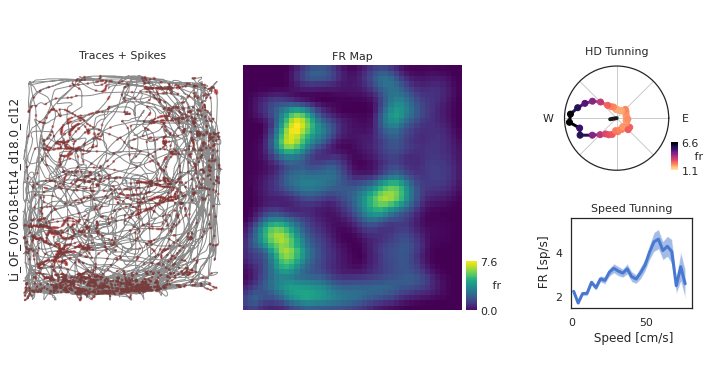

In [1269]:
f,ax = plot_OF(cl_name, *load_cell(idx, metric_scores),)

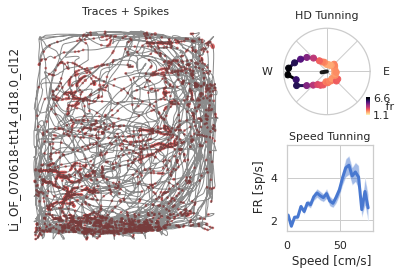

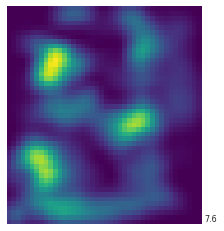

In [1271]:
sns.set_style("whitegrid")
f,ax = plot_OF2(cl_name, *load_cell(idx, metric_scores))
#f.savefig(fig5_path / f'OF_Metrics_{cl_name}_vectors.pdf', bbox_inches='tight', pad_inches=0.2)
f, ax = plot_fr_map2( *load_cell(idx, metric_scores))
#f.savefig(fig5_path / f'OF_Metrics_{cl_name}_raster.png',dpi=300, bbox_inches='tight', pad_inches=0.2)

## Plot a few example rasters

In [149]:
model = 'pos'
thr = 0.05
model_metric='r2'
split='test'
unit_type='cell'
sub_model_table = model_filter_units(model, thr, model_metric, split, unit_type=unit_type)
sub_model_table

unit_id subject       session  session_unit_id unit_type  \
16270      389      Li  Li_OF_062018               10      cell   
19222      462      Li  Li_OF_062718                9      cell   
26126      641      Li  Li_OF_080218                9      cell   
18006      438      Li  Li_OF_062618                8      cell   
19230      463      Li  Li_OF_062718               10      cell   
...        ...     ...           ...              ...       ...   
50590     1244      Cl  Cl_OF_113018                3      cell   
54694     1333      Cl  Cl_OF_120418                2      cell   
20158      487      Li  Li_OF_062818                2      cell   
38550      951      Ne  NE_OF_061818                9      cell   
8254       179      Li  Li_OF_060718                3      cell   

       session_pct_cov  session_valid  tt  tt_cl model split metric     value  \
16270             0.98           True  10      0   pos  test     r2  0.396070   
19222             0.93           True  10      0   pos  test     r2  0.373716   
26126             0.97           True  10     13   pos  test     r2  0.359874   
18006             0.95           True  10      0   pos  test     r2  0.326879   
19230             0.93           True  10      7   pos  test     r2  0.320965   
...                ...            ...  ..    ...   ...   ...    ...       ...   
50590             0.98           True   4      8   pos  test     r2  0.051870   
54694             0.97           True   4      3   pos  test     r2  0.051550   
20158             0.98           True   8      2   pos  test     r2  0.051471   
38550             0.97           True   8      5   pos  test     r2  0.050545   
8254              0.94           True   3     16   pos  test     r2  0.050467   

                             cl_name  
16270   Li_OF_062018-tt10_d18.25_cl0  
19222    Li_OF_062718-tt10_d18.5_cl0  
26126  Li_OF_080218-tt10_d19.75_cl13  
18006   Li_OF_062618-tt10_d18.25_cl0  
19230    Li_OF_062718-tt10_d18.5_cl7  
...                              ...  
50590     Cl_OF_113018-tt4_d12.5_cl8  
54694    Cl_OF_120418-tt4_d12.75_cl3  
20158     Li_OF_062818-tt8_d17.0_cl2  
38550     NE_OF_061818-tt8_d12.5_cl5  
8254    Li_OF_060718-tt3_d17.25_cl16  

[161 rows x 14 columns]

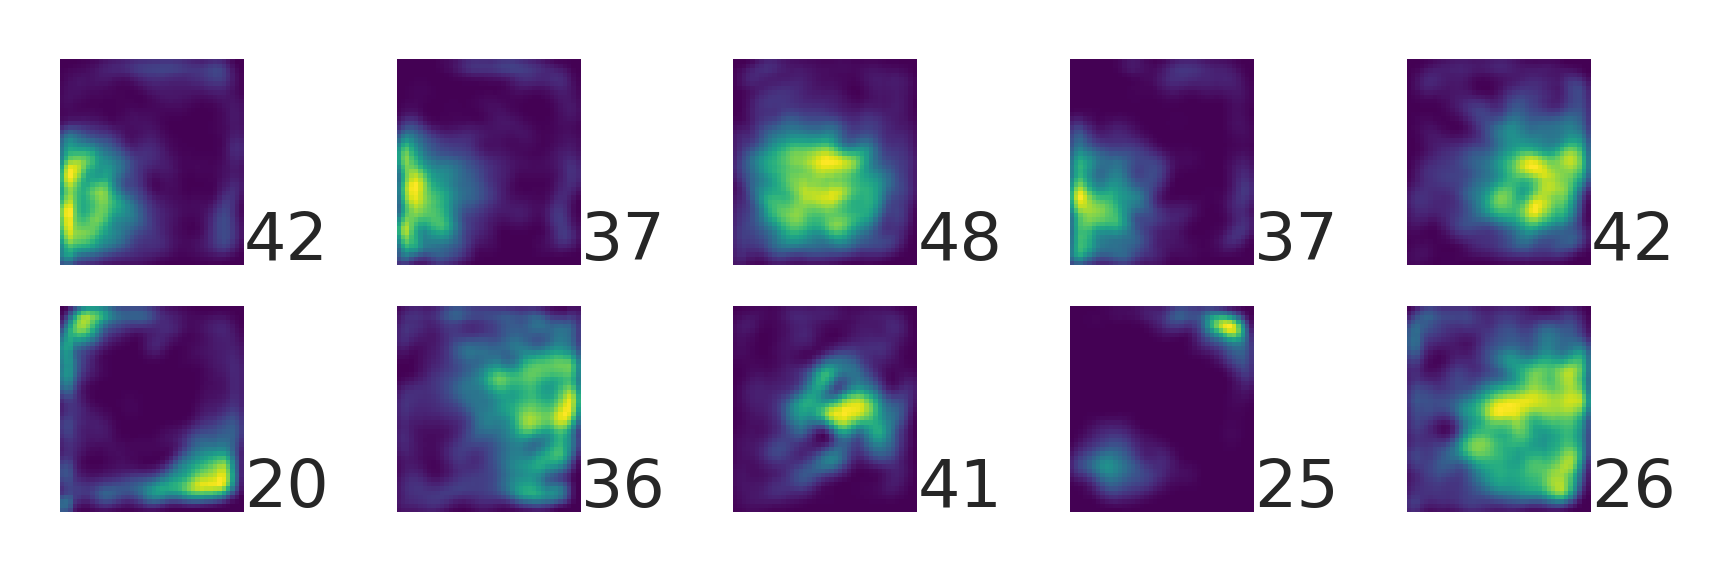

In [1318]:
fontsize=8
def plot_fr_map2(track_data, spikes, fr, fr_map, cl_name=None, ax=None, cbar=False, max_txt=True, cmap='viridis'):
    if ax is None:
        f,ax = plt.subplots(figsize=(4,4))
    else:
        f = ax.figure
    
    vmin, vmax = 0, fr_map.max()
    colors = plt.cm.get_cmap(cmap)(fr_map/vmax)

    ax = sns.heatmap(fr_map, xticklabels=[], yticklabels=[], cmap=cmap, 
                     vmin=0, vmax=vmax, square=True, cbar=False, ax=ax)

    ax.invert_yaxis()
    #ax.set_title('FR Map', fontsize=label_fontsize)

    if cbar:
        cax = getColBar(ax, fr_map.flatten(), cmap=cmap, cax_pos=[1.02,0,0.05,0.2])
        cax.set_ylabel(' fr', rotation='horizontal', va='center', ha='right', fontsize=label_fontsize)

    if cl_name is not None:
        pos = ax.get_position()
        axt = f.add_axes([pos.x0-0.1,pos.y0,0.02,pos.height])
        axt.text(0,.1, cl_name, rotation=90)
        axt.set_axis_off()
        
    if max_txt:
        pos = ax.get_position()
        axt = f.add_axes([pos.x0+pos.width, pos.y0, 0.01,0.1])
        axt.text(0,.1, int(vmax), fontsize=fontsize)
        axt.set_axis_off()
        
    return f, ax

f = plt.figure(figsize=(3.5,1), dpi=600)
n_rows = 2
n_cols = 5
gs = f.add_gridspec(n_rows,n_cols)
ax = np.zeros((n_rows,n_cols), dtype=object)
cnt=0
for ii in range(n_rows):
    for jj in range(n_cols):
        ax[ii, jj] = f.add_subplot(gs[ii,jj])
        plot_fr_map2(*load_cell(sub_model_table.index[cnt], sub_model_table),ax=ax[ii,jj])
        #ax[ii,jj].set_rasterized(True)
        cnt+=1

In [ ]:
def plot_OF3()

In [1319]:
#f.savefig(fig5_path / f'OF_Rasters_thr-{model}.png',dpi=300, bbox_inches='tight', pad_inches=0.2)
#f.savefig(fig5_path / f'OF_Rasters_thr-{model}.pdf',dpi=300, bbox_inches='tight', pad_inches=0.2)
f.savefig(fig5_path / f'OF_Rasters_thr-{model}.pdf',dpi=600, bbox_inches='tight')

## Unit Metric Sig. Overlap

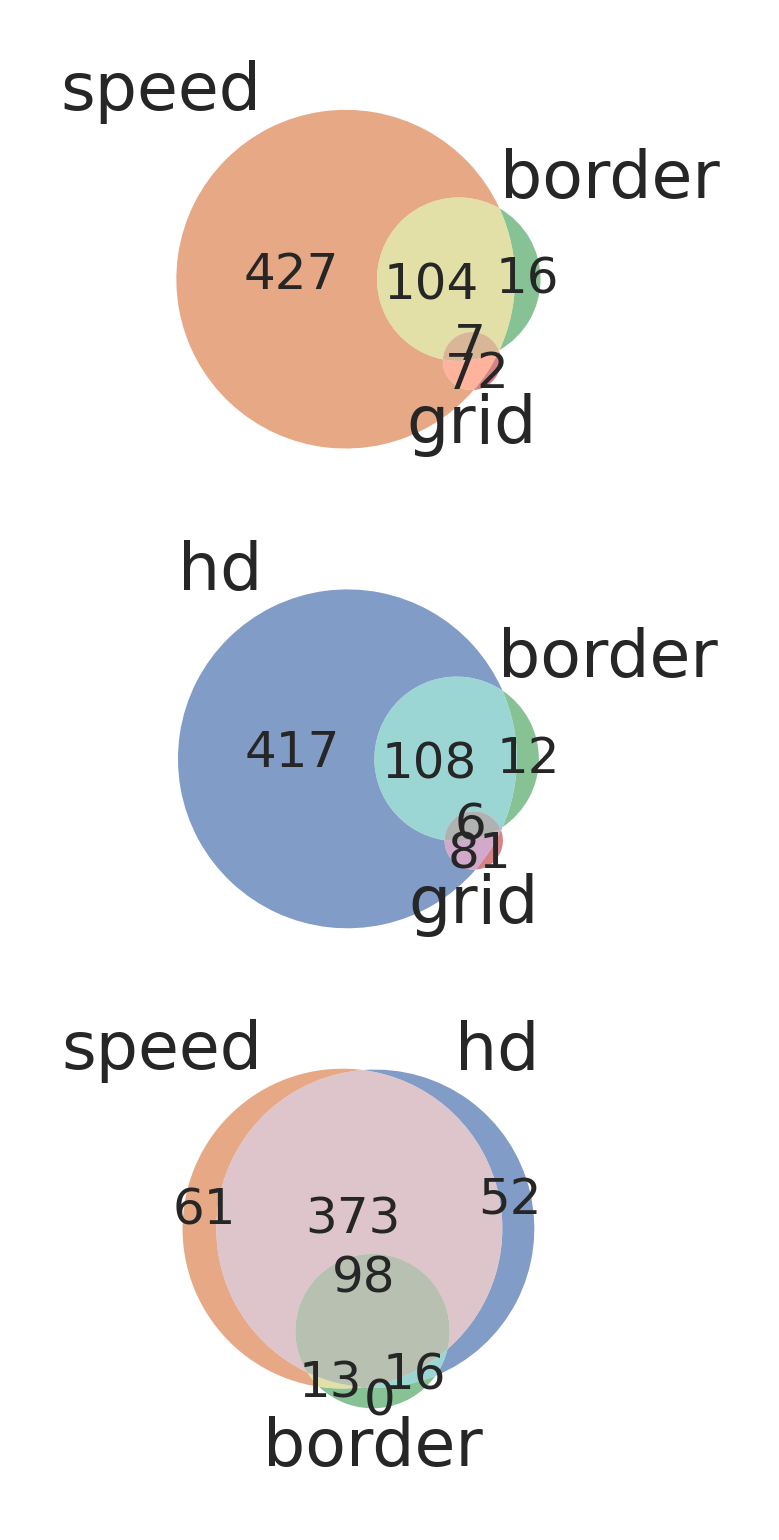

In [1320]:
set_fontsize=6
set_labels_fontsize=8
for unit_type in ['cell']:#['cell', 'mua']:
    set_counts = {}
    for analysis in analyses:
        unit_ids = set(metric_scores[(metric_scores['analysis_type']==analysis) & 
                                     (metric_scores['unit_type']==unit_type) & 
                                     (metric_scores['sig']==1) & 
                                     (metric_scores['session_valid'])].cl_name)
        set_counts[analysis] = unit_ids

    f,ax = plt.subplots(3,1, figsize=(1,3), dpi=600)
    sets = [['speed', 'border', 'grid'], ['hd', 'border', 'grid'], ['speed', 'hd', 'border']]
    type_color = {'hd': analyses_colors[0],
                  'speed': analyses_colors[1],
                  'border': analyses_colors[2],
                  'grid': analyses_colors[3]}

    for ii in range(3):
        set_lists = [set_counts[jj] for jj in sets[ii]]
        set_colors = [type_color[analysis] for analysis in sets[ii]]
        out = venn3(set_lists, set_labels=sets[ii], ax=ax[ii], alpha=0.7,set_colors=set_colors)
        #out = venn3(set_lists, set_labels=['']*3, ax=ax[ii], alpha=0.7,set_colors=set_colors)
        for text in out.set_labels:
            text.set_fontsize(set_labels_fontsize)
        for x in range(len(out.subset_labels)):
            if out.subset_labels[x] is not None:
                out.subset_labels[x].set_fontsize(set_fontsize)

    # store
    f.savefig(fig5_path/(f'Venn_{unit_type}_Counts2.pdf'), bbox_inches='tight', dpi=600)

['#DD8452', '#4C72B0', '#55A868']

## Units Metrics 

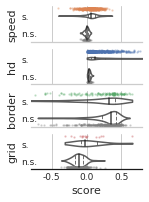

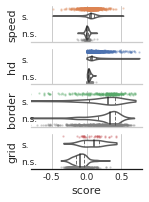

In [153]:
fontsize=11
tick_fontsize=9

for unit_type in ['cell', 'mua']:

    analyses = ['speed', 'hd', 'border', 'grid']
    f, ax = plt.subplots(4,1, figsize=(2,3))
    gs = f.add_gridspec(n_rows,n_cols,wspace=0.5)

    
    sns.set_style('whitegrid')
    for ii, analysis in enumerate(analyses):
        data_subset = metric_scores[ (metric_scores['unit_type']==unit_type) & 
                                        (metric_scores['analysis_type']==analysis) & 
                                        (metric_scores['session_valid']) ]
        data_subset = data_subset.astype({'sig': 'bool'})        
        data_subset = data_subset.astype({'sig': 'str'})

        sns.violinplot(data=data_subset, x='score', y='sig', order=['True', 'False'], color='white', cut=0, inner='quartile', linecolor='0.1', ax=ax[ii]) 
#         sns.violinplot(data=data_subset, x='score', hue='sig', order=['True', 'False'], split='True', scale='count', color='white', cut=0, inner='quartile', linecolor='0.1', ax=ax[ii]) 
        
        for l in ax[ii].lines:
            l.set_linestyle('--')
            l.set_linewidth(1)
            l.set_color('0.3')
            l.set_alpha(0.8)
        for l in ax[ii].lines[1::3]:
            l.set_linestyle('-')
            l.set_linewidth(1.5)
            l.set_color('0.1')
            l.set_alpha(0.8)
        for c in ax[ii].collections:
            c.set_edgecolor('0.2')
            c.set_alpha(0.8)
        
            
        sig_points = data_subset.sig=='True'
        ax[ii].scatter(x=data_subset['score'][sig_points], y=-0.4 + 0.1*(np.random.rand(sig_points.sum())-0.5), s=2, color=type_color[analysis], alpha=0.25)
        
        sig_points = data_subset.sig=='False'
        ax[ii].scatter(x=data_subset['score'][sig_points], y=1.4 + 0.05*(np.random.rand(sig_points.sum())-0.5), s=2, color='grey', alpha=0.25)


#         data_subset_sig = metric_scores[ (metric_scores['unit_type']==unit_type) & 
#                                         (metric_scores['analysis_type']==analysis) & 
#                                         (metric_scores['sig']) &
#                                         (metric_scores['session_valid']) ]

#         sns.violinplot(data=data_subset_sig, x='score', color='white', cut=0, ax=ax[ii],  inner='quartile')  
#         #sns.boxplot(data=data_subset_sig, x='score', color='white', whis=100, ax=ax[ii])
#         sns.stripplot(data=data_subset_sig, x='score', color=type_color[analysis], alpha=0.5, ax=ax[ii])

#         data_subset = metric_scores[ (metric_scores['unit_type']==unit_type) & 
#                                         (metric_scores['analysis_type']==analysis) &
#                                         (metric_scores['session_valid']) ]

#         sns.stripplot(data=data_subset, x='score', color='grey', alpha=0.1, jitter=0.2, ax=ax[ii])
        ax[ii].set_xlabel('')
        ax[ii].set_xlim([-0.8,0.8])
        if ii==3:
            xticks = ax[ii].get_xticks() 
            ax[ii].set_xticklabels(np.around(xticks,1), fontsize=tick_fontsize)
        else:
            ax[ii].set_xticklabels([])
    
        ax[ii].set_ylabel(analysis, fontsize=fontsize)
        for pos in ['right', 'top', 'left']:
            ax[ii].spines[pos].set_visible(False)
        ax[ii].set_xlabel('')
            
        xticklabels=ax[ii].get_xticklabels() 
        for l in xticklabels:
            pos = l.get_position()
            l.set_position((pos[0], pos[1]+0.2))
        ax[ii].set_xticklabels(xticklabels, fontsize=tick_fontsize)
        
        ax[ii].set_yticklabels(['s.', 'n.s.'], fontsize=tick_fontsize, ha='left')
        #ax[ii].set_frame_on(False)
        #ax[ii].get_xaxis().tick_bottom()
    ax[3].set_xlabel('score', fontsize=fontsize)
    ax[3].spines['bottom'].set_color('k')

    #f.savefig(fig5_path/(f'MetricsScores_{unit_type}.pdf'), bbox_inches='tight')

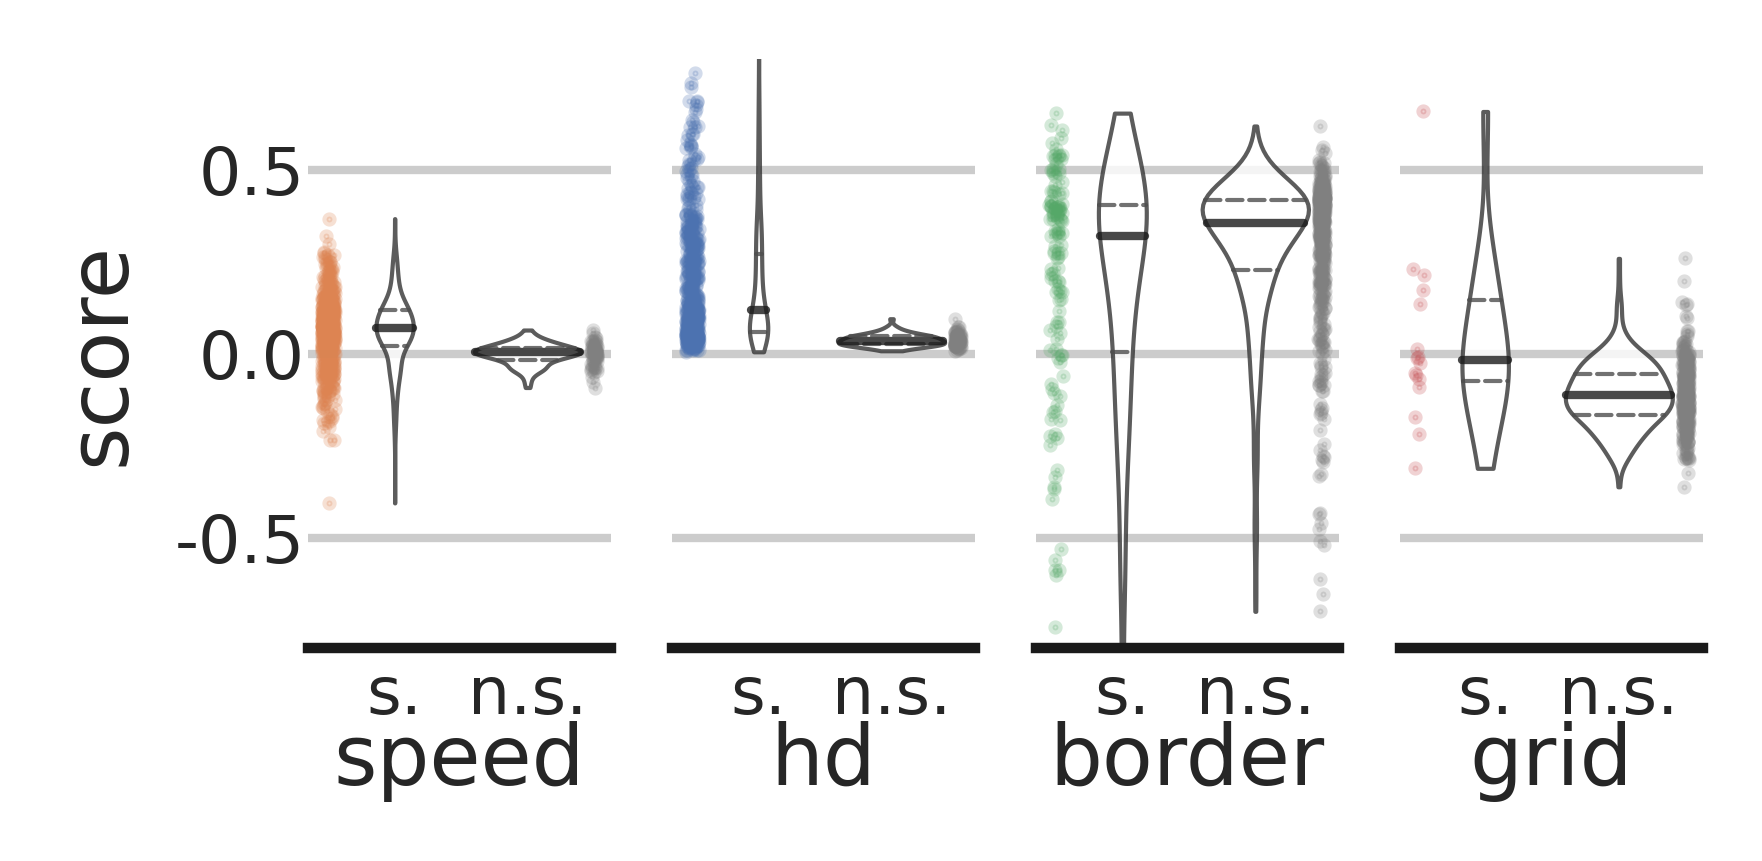

In [1350]:
fontsize=10
tick_fontsize=8
type_color = {'true': 'k',
              'hd': analyses_colors[0],
              'sp': analyses_colors[1],
              'speed': analyses_colors[1],
              'border': analyses_colors[2],
              'grid': analyses_colors[3],
              'pos': analyses_colors[4]}

for unit_type in ['cell']:#['cell', 'mua']:

    analyses = ['speed', 'hd', 'border', 'grid']
    f, ax = plt.subplots(1,4, figsize=(3,1.3), dpi=600)
    
    sns.set_style('whitegrid')
    for ii, analysis in enumerate(analyses):
        data_subset = metric_scores[ (metric_scores['unit_type']==unit_type) & 
                                        (metric_scores['analysis_type']==analysis) & 
                                        (metric_scores['session_valid']) ]
        data_subset = data_subset.astype({'sig': 'bool'})        
        data_subset = data_subset.astype({'sig': 'str'})

        sns.violinplot(data=data_subset, y='score', x='sig', order=['True', 'False'], color='white', cut=0, inner='quartile', linewidth=0.5, ax=ax[ii]) 
#         sns.violinplot(data=data_subset, x='score', hue='sig', order=['True', 'False'], split='True', scale='count', color='white', cut=0, inner='quartile', linecolor='0.1', ax=ax[ii]) 
        
        for l in ax[ii].lines:
            l.set_linestyle('--')
            l.set_linewidth(0.5)
            l.set_color('0.3')
            l.set_alpha(0.8)
        for l in ax[ii].lines[1::3]:
            l.set_linestyle('-')
            l.set_linewidth(1)
            l.set_color('0.1')
            l.set_alpha(0.8)
        for c in ax[ii].collections:
            c.set_edgecolor('0.2')
            c.set_alpha(0.8)
        
            
        sig_points = data_subset.sig=='True'
        ax[ii].scatter(y=data_subset['score'][sig_points], x=-0.5 + 0.1*(np.random.rand(sig_points.sum())-0.5), s=0.5, color=type_color[analysis], edgecolors=None, alpha=0.25)
        
        sig_points = data_subset.sig=='False'
        ax[ii].scatter(y=data_subset['score'][sig_points], x=1.5 + 0.05*(np.random.rand(sig_points.sum())-0.5), s=0.5, color='grey', alpha=0.25, edgecolors=None)
        
#         data_subset_sig = metric_scores[ (metric_scores['unit_type']==unit_type) & 
#                                         (metric_scores['analysis_type']==analysis) & 
#                                         (metric_scores['sig']) &
#                                         (metric_scores['session_valid']) ]

#         sns.violinplot(data=data_subset_sig, x='score', color='white', cut=0, ax=ax[ii],  inner='quartile')  
#         #sns.boxplot(data=data_subset_sig, x='score', color='white', whis=100, ax=ax[ii])
#         sns.stripplot(data=data_subset_sig, x='score', color=type_color[analysis], alpha=0.5, ax=ax[ii])

#         data_subset = metric_scores[ (metric_scores['unit_type']==unit_type) & 
#                                         (metric_scores['analysis_type']==analysis) &
#                                         (metric_scores['session_valid']) ]

#         sns.stripplot(data=data_subset, x='score', color='grey', alpha=0.1, jitter=0.2, ax=ax[ii])
        for pos in ['left', 'top', 'right']:
            ax[ii].spines[pos].set_visible(False)
        ax[ii].spines['bottom'].set_color('k')
        
        ax[ii].set_ylabel('')
        ax[ii].set_ylim([-0.8,0.8])
        yticks = ax[ii].get_yticks() 
        ax[ii].set_yticklabels(np.around(yticks,1))
         
        if ii==0:
            yticklabels=ax[ii].get_yticklabels() 
            for l in yticklabels:
                pos = l.get_position()
                l.set_position((pos[0]+0.25, pos[1]))
            ax[ii].set_yticklabels(yticklabels, fontsize=tick_fontsize)
        else:
            ax[ii].set_yticklabels([])

            
        ax[ii].set_xticklabels(['s.', 'n.s.'], fontsize=tick_fontsize)
        xticklabels=ax[ii].get_xticklabels() 
        for l in yticklabels:
            pos = l.get_position()
            #l.set_position((pos[0], pos[1]+0.2))
        ax[ii].set_xticklabels(xticklabels, fontsize=tick_fontsize,va='bottom')
        ax[ii].set_xlabel(analysis, fontsize=fontsize, va='center')

        #ax[ii].set_frame_on(False)
        #ax[ii].get_yaxis().tick_r()
    ax[0].set_ylabel('score', fontsize=fontsize)

    f.savefig(fig5_path/(f'MetricsScores_{unit_type}2.pdf'), bbox_inches='tight', dpi=600)

In [943]:
type_color

{'true': 'k',
 'hd': '#4C72B0',
 'sp': '#DD8452',
 'border': '#55A868',
 'grid': '#C44E52',
 'pos': '#8172B3'}

In [200]:
list(ax[ii].get_yticklabels())

[Text(0, 0, 'True'), Text(0, 1, 'False')]

## Units Model Scores

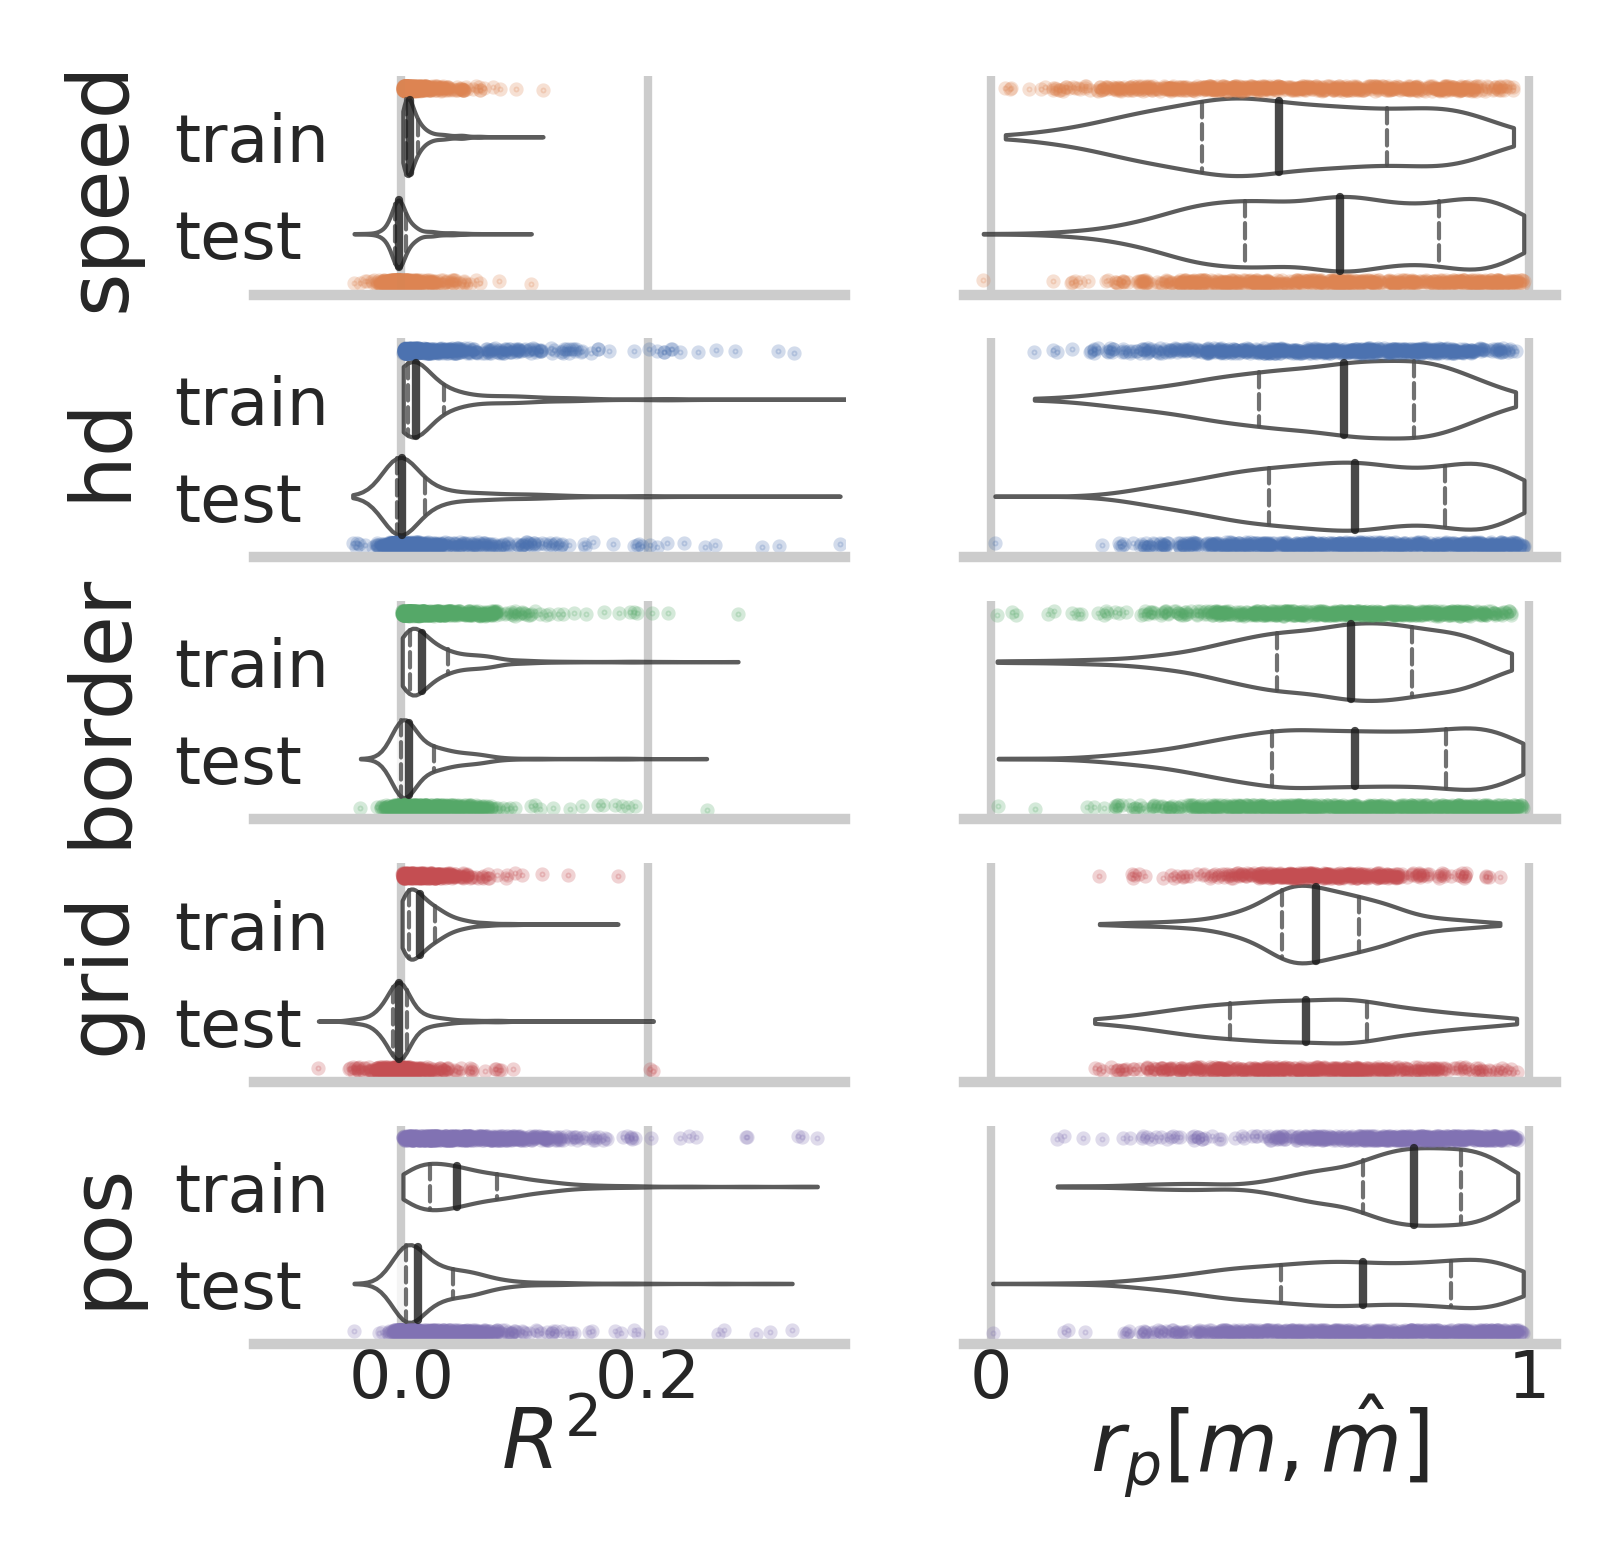

In [1347]:
label_fontsize=10
tick_fontsize=8
type_color = {'hd': analyses_colors[0],
              'speed': analyses_colors[1],
              'border': analyses_colors[2],
              'grid': analyses_colors[3],
              'pos': analyses_colors[4]}


for unit_type in ['cell']:#['cell', 'mua']:
    
    #f, ax = plt.subplots(5,2, figsize=(2.8,3), constrained_layout=True, dpi=600)
    f, ax = plt.subplots(5,2, figsize=(2.8,2.8), dpi=600)
    for jj, metric in enumerate(['r2', 'map_r']):
        analyses = ['speed', 'hd', 'border', 'grid', 'pos']
        sns.set_style('whitegrid')
        for ii, analysis in enumerate(analyses):
            data_subset = model_scores[ (model_scores['unit_type']==unit_type) & 
                                        (model_scores['model']==analysis) & 
                                        (model_scores['metric']==metric) &
                                        (model_scores['session_valid']) 
                                      ]
            data_subset = data_subset[~data_subset.isin([np.nan, np.inf, -np.inf]).any(1)]

            #sns.boxplot(data=data_subset, x='value', y='split', color='white', whis=100, ax=ax[ii])
            sns.violinplot(data=data_subset, x='value', y='split', color='white', order=['train','test'], cut=0, ax=ax[ii,jj],inner='quartile', linewidth=0.5)  
            #sns.stripplot(data=data_subset, x='value', y='split', color=type_color[analysis], alpha=0.2, ax=ax[ii])

            for l in ax[ii,jj].lines:
                l.set_linestyle('--')
                l.set_linewidth(0.5)
                l.set_color('0.3')
                l.set_alpha(0.8)
            for l in ax[ii,jj].lines[1::3]:
                l.set_linestyle('-')
                l.set_linewidth(1)
                l.set_color('0.1')
                l.set_alpha(0.8)
            for c in ax[ii,jj].collections:
                c.set_edgecolor('0.2')
                #c.set_linewidth(1.5)
                c.set_alpha(0.8)

            split_points = data_subset.split == 'train'
            ax[ii,jj].scatter(x=data_subset['value'][split_points], y=-0.5 + 0.05*(np.random.rand(split_points.sum())-0.5),
                           s=0.5, color=type_color[analysis], alpha=0.25)

            split_points = data_subset.split == 'test'
            ax[ii,jj].scatter(x=data_subset['value'][split_points], y=1.5 + 0.05*(np.random.rand(split_points.sum())-0.5),
                           s=0.5, color=type_color[analysis], alpha=0.25)


            if metric=='r2':
                ax[ii,jj].set_xlabel(r'$R^2$', fontsize=label_fontsize, va='center')
                if unit_type=='cell':
                    ax[ii,jj].set_xlim([-0.15,0.45])
                else:
                    ax[ii,jj].set_xlim([-0.2,0.45])
            elif metric=='map_r':
                ax[ii,jj].set_xlabel(r'$r_p[m,\hat{m}]$', fontsize=label_fontsize, va='center')
                ax[ii,jj].set_xlim([-0.05,1.05])

            if ii==4:
                xticks = ax[ii,jj].get_xticks() 
                if metric=='map_r':
                    ax[ii,jj].set_xticks([0,1])
                    ax[ii,jj].set_xticklabels([0, '1'], fontsize=tick_fontsize, va='center')
                else:
                    ax[ii,jj].set_xticklabels(np.around(xticks,1), fontsize=tick_fontsize, va='center')
                
                xticklabels=ax[ii,jj].get_xticklabels() 
                for l in xticklabels:
                    pos = l.get_position()
                    l.set_position((pos[0], pos[1]+0.2))
                ax[ii,jj].set_xticklabels(xticklabels, fontsize=tick_fontsize)
                
            else:
                ax[ii,jj].set_xticklabels([])
           
            if ii<4:
                ax[ii,jj].set_xlabel('')
                
            if jj==0:
                ax[ii, jj].set_ylabel(analysis, fontsize=label_fontsize)
                ax[ii, jj].set_yticklabels(['train', 'test'], fontsize=tick_fontsize, ha='left')
            else:
                ax[ii,jj].set_ylabel('')
                ax[ii,jj].set_yticklabels([])
            
            for pos in ['right', 'top', 'left']:
                ax[ii,jj].spines[pos].set_visible(False)


f.savefig(fig5_path/(f'ModelScores_{unit_type}.pdf'), bbox_inches='tight', dpi=600)

In [1340]:
data_subset[split_points]

unit_id subject       session  session_unit_id unit_type  \
450          0      Li  Li_OF_052818                0      cell   
458          1      Li  Li_OF_052818                1      cell   
466          2      Li  Li_OF_052818                2      cell   
1490        14      Li  Li_OF_052918                0      cell   
1498        15      Li  Li_OF_052918                1      cell   
...        ...     ...           ...              ...       ...   
88266     2202      Mi  Mi_OF_021020                0      cell   
88274     2203      Mi  Mi_OF_021020                1      cell   
88626     2215      Mi  Mi_OF_021220                0      cell   
88706     2217      Mi  Mi_OF_021720                0      cell   
88754     2219      Mi  Mi_OF_021820                0      cell   

       session_pct_cov  session_valid  tt  tt_cl model split metric     value  \
450               0.96           True   7      8   pos  test  map_r  0.741915   
458               0.96           True   8      4   pos  test  map_r  0.475678   
466               0.96           True   8     18   pos  test  map_r  0.789085   
1490              0.97           True   3      5   pos  test  map_r  0.391969   
1498              0.97           True   3     17   pos  test  map_r  0.770371   
...                ...            ...  ..    ...   ...   ...    ...       ...   
88266             0.93           True  12      8   pos  test  map_r  0.967222   
88274             0.93           True  12     13   pos  test  map_r  0.282734   
88626             0.96           True  12     20   pos  test  map_r  0.912468   
88706             0.94           True  14      1   pos  test  map_r  0.580345   
88754             0.92           True  14     11   pos  test  map_r  0.603126   

                              cl_name  
450       Li_OF_052818-tt7_d17.25_cl8  
458       Li_OF_052818-tt8_d16.25_cl4  
466      Li_OF_052818-tt8_d16.25_cl18  
1490      Li_OF_052918-tt3_d16.75_cl5  
1498     Li_OF_052918-tt3_d16.75_cl17  
...                               ...  
88266   Mi_OF_021020-tt12_d16.125_cl8  
88274  Mi_OF_021020-tt12_d16.125_cl13  
88626  Mi_OF_021220-tt12_d16.125_cl20  
88706   Mi_OF_021720-tt14_d16.375_cl1  
88754  Mi_OF_021820-tt14_d16.375_cl11  

[616 rows x 14 columns]

## predicted map correlations

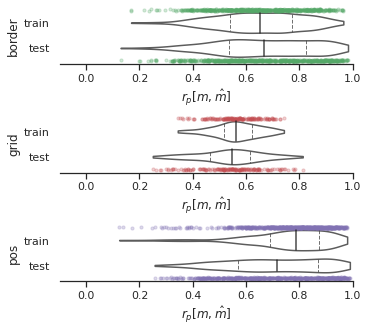

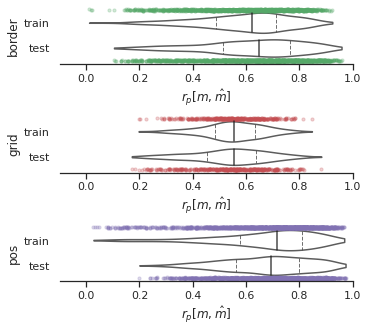

In [15]:
metric='map_r'
analyses = ['border', 'grid', 'pos', 'hd', '']
for unit_type in ['cell', 'mua']:
    analyses = ['border', 'grid', 'pos']
    f, ax = plt.subplots(3,1, figsize=(5,4.5), constrained_layout=True)
    sns.set_style('white')
    for ii, analysis in enumerate(analyses):
        data_subset = model_scores[ (model_scores['unit_type']==unit_type) & 
                                    (model_scores['model']==analysis) & 
                                    #(model_scores['split']==split) &
                                    (model_scores['metric']==metric) &
                                    (model_scores['session_valid']) 
                                  ]
        data_subset = data_subset[~data_subset.isin([np.nan, np.inf, -np.inf]).any(1)]

        sns.violinplot(data=data_subset, x='value', y='split', color='white', cut=0, ax=ax[ii],  inner='quartile')  
        #sns.stripplot(data=data_subset, x='value', y='split', color=type_color[analysis], alpha=0.2, ax=ax[ii])

        for l in ax[ii].lines:
            l.set_linestyle('--')
            l.set_linewidth(1)
            l.set_color('0.3')
            l.set_alpha(0.8)
        for l in ax[ii].lines[1::3]:
            l.set_linestyle('-')
            l.set_linewidth(1.5)
            l.set_color('0.1')
            l.set_alpha(0.8)
        for c in ax[ii].collections:
            c.set_edgecolor('0.2')
            c.set_alpha(0.8)
            
        split_points = data_subset.split == 'train'
        ax[ii].scatter(x=data_subset['value'][split_points], y=-0.5 + 0.05*(np.random.rand(split_points.sum())-0.5),
                       s=10, color=type_color[analysis], alpha=0.25)
        
        split_points = data_subset.split == 'test'
        ax[ii].scatter(x=data_subset['value'][split_points], y=1.5 + 0.05*(np.random.rand(split_points.sum())-0.5),
                       s=10, color=type_color[analysis], alpha=0.25)

        
        ax[ii].set_ylabel(analysis)
        for pos in ['right', 'top', 'left']:
            ax[ii].spines[pos].set_visible(False)
        ax[ii].get_xaxis().tick_bottom()

        ax[ii].set_xlabel(r'$r_p[m,\hat{m}]$')
        ax[ii].set_xlim([-0.1,1])
                
    f.savefig(fig5_path/(f'ModelScores_{unit_type}_{metric}.pdf'), bbox_inches='tight')

model coefficients vs bins for speed and HD

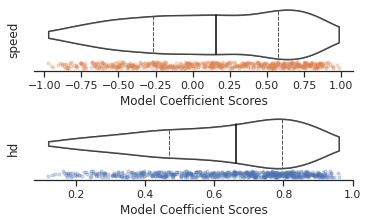

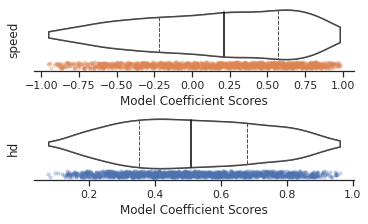

In [652]:
metric='map_r'
analyses = ['speed', 'hd']
split='train'
for unit_type in ['cell', 'mua']:
    f, ax = plt.subplots(2,1, figsize=(5,3), constrained_layout=True)
    sns.set_style('white')
    for ii, analysis in enumerate(analyses):
        data_subset = model_scores[ (model_scores['unit_type']==unit_type) & 
                                    (model_scores['model']==analysis) & 
                                    (model_scores['split']==split) &
                                    (model_scores['metric']==metric) &
                                    (model_scores['session_valid']) 
                                  ]
        data_subset = data_subset[~data_subset.isin([np.nan, np.inf, -np.inf]).any(1)]

        #sns.boxplot(data=data_subset, x='value', y='split', color='white', whis=100, ax=ax[ii])
        sns.violinplot(data=data_subset, x='value',  color='white', cut=0, ax=ax[ii], inner='quartile') 
        #sns.stripplot(data=data_subset, x='value', color=type_color[analysis], alpha=0.2, ax=ax[ii])
        
        sns.violinplot(data=data_subset, x='value', color='white', cut=0, ax=ax[ii],  inner='quartile')  
        #sns.stripplot(data=data_subset, x='value', y='split', color=type_color[analysis], alpha=0.2, ax=ax[ii])

        for l in ax[ii].lines:
            l.set_linestyle('--')
            l.set_linewidth(1)
            l.set_color('0.3')
            l.set_alpha(0.8)
        for l in ax[ii].lines[1::3]:
            l.set_linestyle('-')
            l.set_linewidth(1.5)
            l.set_color('0.1')
            l.set_alpha(0.8)
        for c in ax[ii].collections:
            c.set_edgecolor('0.2')
            c.set_alpha(0.8)

        n_ppints = data_subset.shape[0]
        ax[ii].scatter(x=data_subset['value'], y=0.5 + 0.1*(np.random.rand(n_ppints)-0.5),
                       s=10, color=type_color[analysis], alpha=0.25)



        ax[ii].set_ylabel(analysis)
        for pos in ['right', 'top', 'left']:
            ax[ii].spines[pos].set_visible(False)
        ax[ii].get_xaxis().tick_bottom()

        ax[ii].set_xlabel("Model Coefficient Scores")
    
    f.savefig(fig5_path/(f'ModelScores_{unit_type}_{metric}_sphd.pdf'), bbox_inches='tight')

## Pair plot between metric and model scores

Text(0, 0.5, '$r_s$')

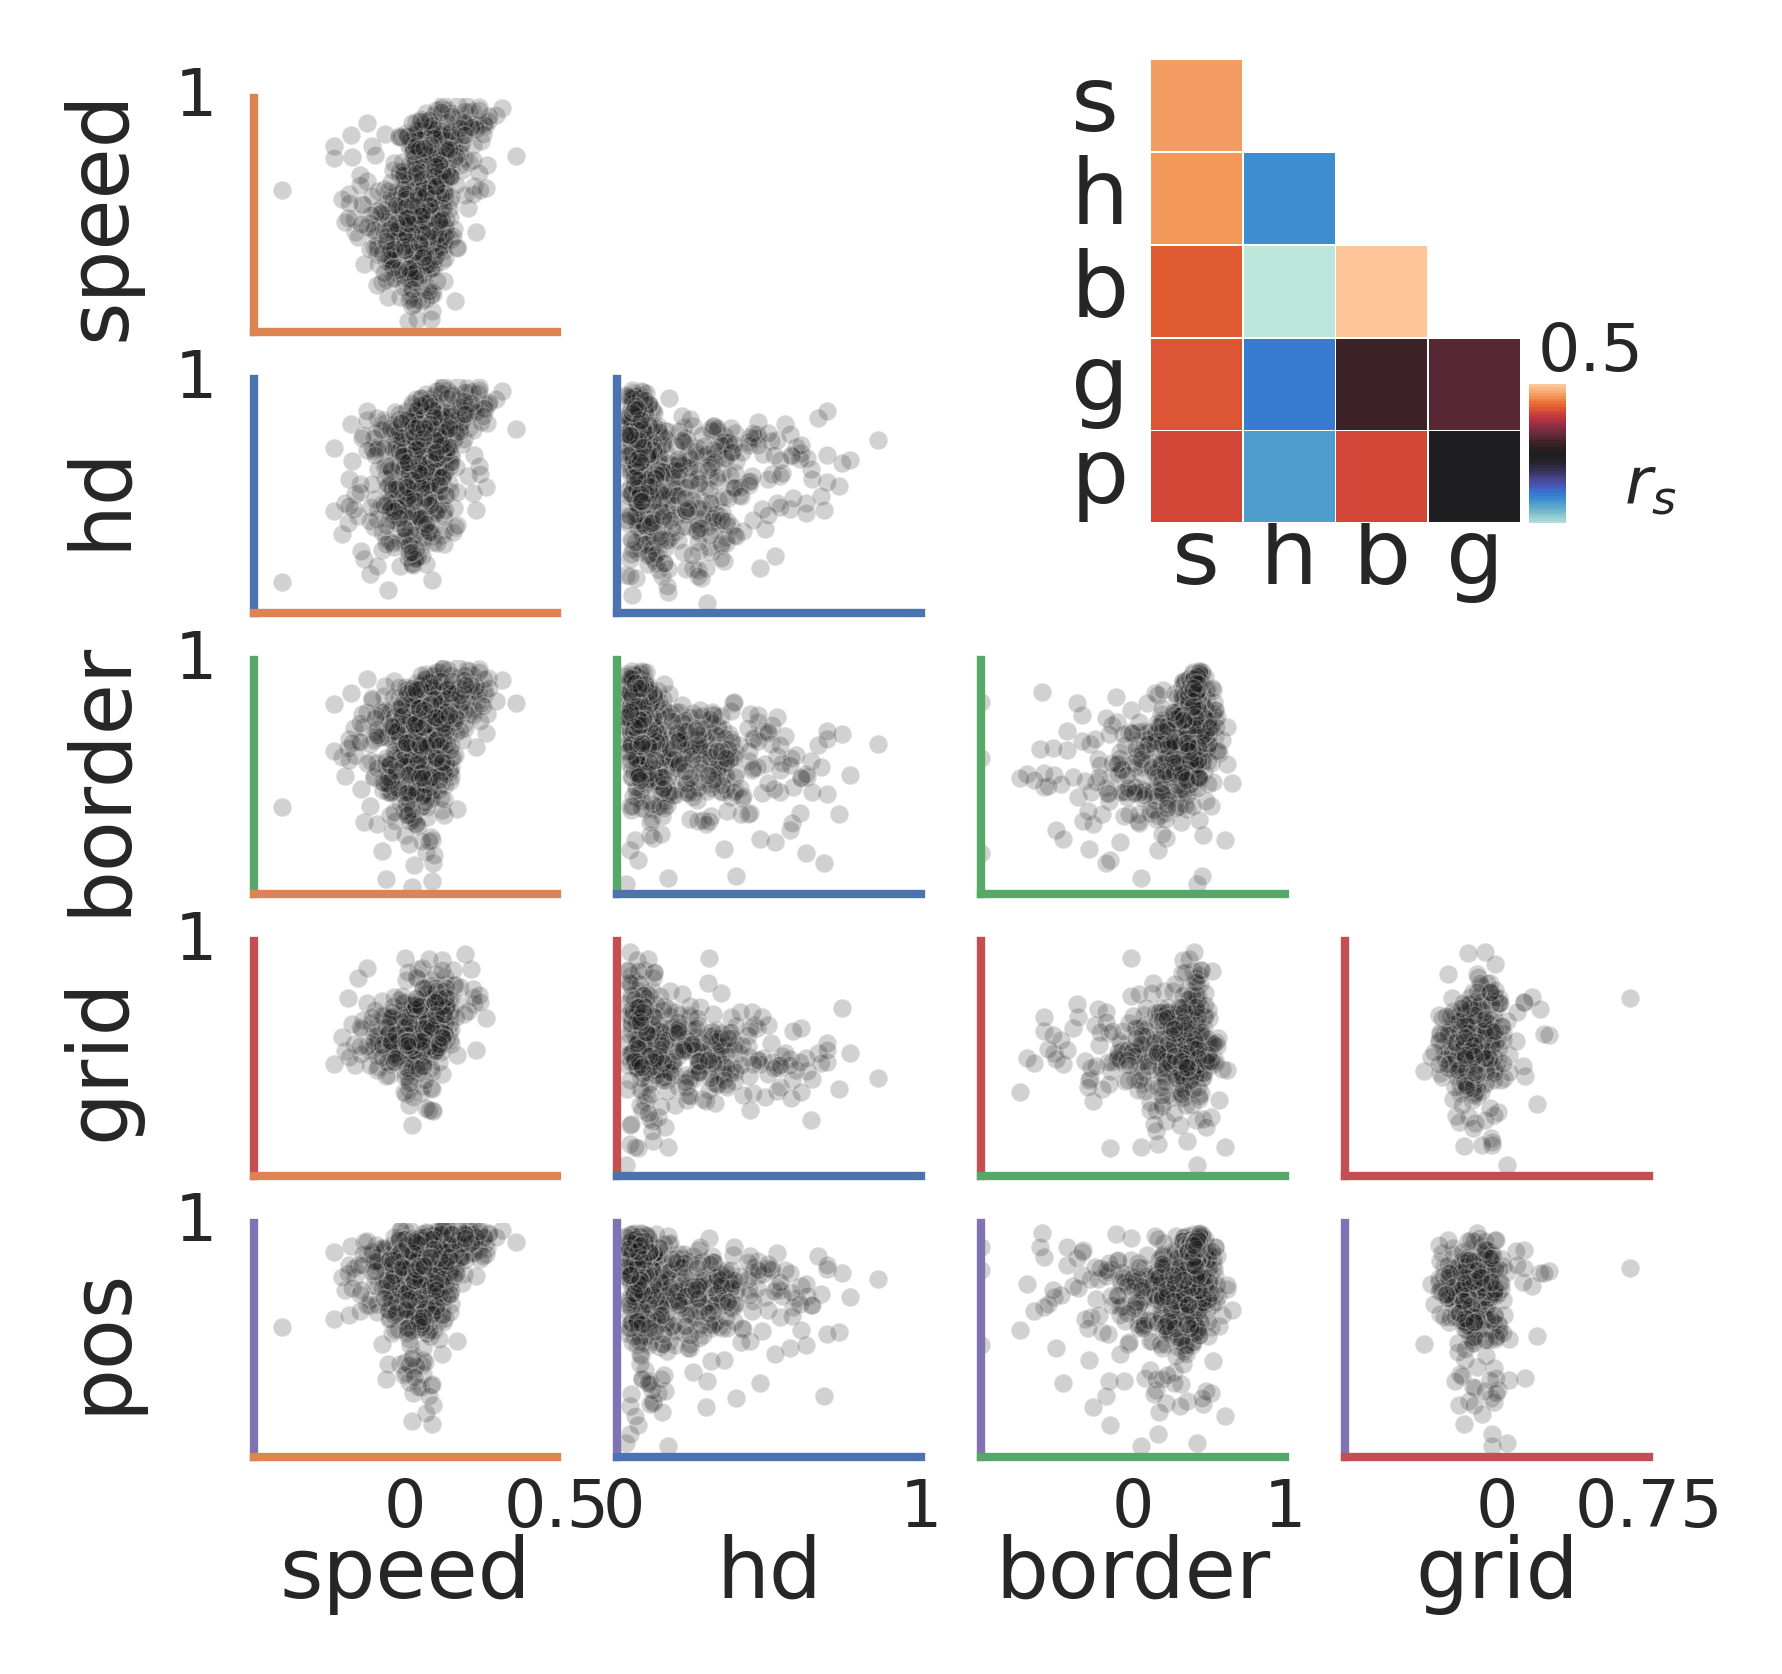

In [1360]:


model_metric = 'map_r'
split = 'train'
unit_type = 'cell'

label_fontsize=10
tick_fontsize=8

metric_types = ['speed', 'hd', 'border', 'grid']
models = ['speed', 'hd', 'border', 'grid', 'pos']
type_color = {'true': 'k',
              'hd': analyses_colors[0],
              'sp': analyses_colors[1],
              'speed': analyses_colors[1],
              'border': analyses_colors[2],
              'grid': analyses_colors[3],
              'pos': analyses_colors[4]}


f = plt.figure(figsize=(3,3), dpi=600)# constrained_layout=True)
n_rows = 5
n_cols = 4
gs = f.add_gridspec(n_rows,n_cols)
sns.set_style('white')
ax = np.zeros((n_rows,n_cols), dtype=object)
for ii in range(n_rows):
    for jj in range(ii+1):
        if jj<n_cols:
            ax[ii, jj] = f.add_subplot(gs[ii,jj])
            for pos in ['right', 'top']:
                ax[ii,jj].spines[pos].set_visible(False)
                #ax[ii].get_xaxis().tick_bottom()
ax_s = f.add_subplot(gs[0:2,2:])
p = ax_s.get_position()
ax_s.set_position([p.x0+0.03, p.y0+0.05, p.width*0.9, p.height*0.9])

cc = np.zeros((n_rows, n_cols))
for ii in range(n_rows):
    model = models[ii]
    for jj in range(ii+1):
        if jj < n_cols:
            metric_type = metric_types[jj]
            ax[ii,jj].clear()
            if unit_type == 'all':
                y_subset =  [(model_scores['model']==model) & 
                            (model_scores['metric']==model_metric) & 
                            (model_scores['split']==split) & 
                            (model_scores['session_valid'])][0]

            else:
                y_subset =  [(model_scores['model']==model) & 
                            (model_scores['metric']==model_metric) & 
                            (model_scores['split']==split) &
                            (model_scores['unit_type']==unit_type) &
                            (model_scores['session_valid'])][0]

            suid = model_scores[y_subset].unit_id
            x_subset = (metric_scores['analysis_type']==metric_type) & (metric_scores['unit_id'].isin(suid))
            
            joint_data = model_scores.loc[y_subset, ['subject', 'unit_type', 'model', 'value']].copy()
            joint_data.loc[:, 'y_var'] = joint_data['value'].values.astype(float)
            joint_data.loc[:, 'x_var'] = metric_scores.loc[x_subset, 'score'].values.astype(float)
            joint_data.dropna(inplace=True)
            
            cc[ii,jj] = rs.spearman(joint_data.y_var, joint_data.x_var)
            sns.scatterplot(data=joint_data,x='x_var', y='y_var', color='k', alpha=0.2, legend=False, ax=ax[ii,jj], **{'s':5, 'edgecolors':None})
                                
            if metric_type=='speed':
                ax[ii,jj].set_xlim([-0.5, .5])    
            elif metric_type=='hd':
                ax[ii,jj].set_xlim([-0.02, 1])    
            elif metric_type=='border':
                ax[ii,jj].set_xlim([-1, 1])
            elif metric_type=='grid':
                ax[ii,jj].set_xlim([-0.75, 0.75])
                
            xmax = ax[ii,jj].get_xlim()[1]

            
            ax[ii,jj].set_xticklabels('')
            ax[ii,jj].set_yticklabels('')

            ax[ii,jj].set_xlabel('')
            ax[ii,jj].set_ylabel('')
                
            if jj==0:
                if model_metric=='r2':
                    ax[ii,jj].set_ylim([-0.05, 0.45])
                    ymax = ax[ii,jj].get_ylim()[1]
                    ax[ii,jj].set_yticks([0, ymax])
                    ax[ii,jj].set_yticklabels(['', ymax], ha='center', va='center', fontsize=tick_fontsize)
                elif model_metric=='map_r':                  
                    ax[ii,jj].set_ylim([-0.02, 1])
                    ymax = ax[ii,jj].get_ylim()[1]
                    ax[ii,jj].set_yticks([0, 1])
                    ax[ii,jj].set_yticklabels(['', '1'], ha='left', va='center', fontsize=tick_fontsize)
                elif model_metric=='coef':
                    if model=='grid':
                        ax[ii,jj].set_ylim((-1,3))
                    ymax = ax[ii,jj].get_ylim()[1]
                    ax[ii,jj].set_yticks([0, ymax])
                    ax[ii,jj].set_yticklabels([0, np.around(ymax,1)], ha='center', va='center', fontsize=tick_fontsize)

                ax[ii,jj].set_ylabel(model, fontsize=label_fontsize)#, va='center', ha='right')                

            if ii==(n_rows-1):
                ax[ii,jj].set_xlabel(metric_type, fontsize=label_fontsize, va='center')
                ax[ii,jj].set_xticks([0, xmax])
                ax[ii,jj].set_xticklabels([0, xmax], va='bottom',  fontsize=tick_fontsize)
                ax[ii,jj].xaxis.set_tick_params(pad=4)
                
                if metric_type in ['hd','border']:
                    ax[ii,jj].set_xticklabels([0, 1], va='bottom',  fontsize=tick_fontsize)
                
                #ax[ii,jj].get_xaxis().tick_bottom()
                
            ax[ii,jj].spines['left'].set_color(type_color[model])
            ax[ii,jj].spines['left'].set_linewidth(1)
            ax[ii,jj].spines['bottom'].set_color(type_color[metric_type])
            ax[ii,jj].spines['bottom'].set_linewidth(1)

cmap = 'icefire'
mask = np.zeros_like(cc)
mask[np.triu_indices_from(mask,1)] = True
ax_s = sns.heatmap(cc, center=0, mask=mask, xticklabels=['s','h','b','g'], cmap=cmap, yticklabels=['s','h','b','g','p'], square=True, cbar=False, ax=ax_s, linewidths=0.1)
l = ax_s.get_xticklabels()
ax_s.set_xticklabels(l, va='bottom', ha='center')
l = ax_s.get_yticklabels()
ax_s.set_yticklabels(l, va='center', ha='left', rotation=0)
cax = getColBar(ax_s, cc.flatten(), cmap=cmap, cax_pos=[1.02,0,0.1,0.3])
cax.set_yticklabels(['',np.around(cc.max(),1)], va='bottom', ha='center', fontsize=tick_fontsize)
cax.set_ylabel(r'$r_s$', rotation=0, ha='right', va='top', fontsize=tick_fontsize)

In [1361]:
f.savefig(fig5_path/(f'ModelvMetric_{unit_type}_{model_metric}_{split}.pdf'), bbox_inches='tight', dpi=600)

In [ ]:
model_metric = 'map_r'
split = 'train'
unit_type = 'cell'

label_fontsize=11
tick_fontsize=9

metric_types = ['speed', 'hd', 'border', 'grid']
models = ['speed', 'hd', 'border', 'grid', 'pos']
type_color = {'true': 'k',
              'hd': analyses_colors[0],
              'sp': analyses_colors[1],
              'speed': analyses_colors[1],
              'border': analyses_colors[2],
              'grid': analyses_colors[3],
              'pos': analyses_colors[4]}

cc = np.zeros((n_rows, n_cols))
for ii in range(n_rows):
    model = models[ii]
    for jj in range(ii+1):
        if jj < n_cols:
            metric_type = metric_types[jj]
            ax[ii,jj].clear()
            if unit_type == 'all':
                y_subset =  [(model_scores['model']==model) & 
                            (model_scores['metric']==model_metric) & 
                            (model_scores['split']==split) & 
                            (model_scores['session_valid'])][0]

            else:
                y_subset =  [(model_scores['model']==model) & 
                            (model_scores['metric']==model_metric) & 
                            (model_scores['split']==split) &
                            (model_scores['unit_type']==unit_type) &
                            (model_scores['session_valid'])][0]

            suid = model_scores[y_subset].unit_id
            x_subset = (metric_scores['analysis_type']==metric_type) & (metric_scores['unit_id'].isin(suid))
            
            joint_data = model_scores.loc[y_subset, ['subject', 'unit_type', 'model', 'value']].copy()
            joint_data.loc[:, 'y_var'] = joint_data['value'].values.astype(float)
            joint_data.loc[:, 'x_var'] = metric_scores.loc[x_subset, 'score'].values.astype(float)
            joint_data.dropna(inplace=True)
            
            cc[ii,jj] = rs.spearman(joint_data.y_var, joint_data.x_var)
            sns.scatterplot(data=joint_data,x='x_var', y='y_var', color='k', alpha=0.2, legend=False, ax=ax[ii,jj], **{'s':5})
                                
            if metric_type=='speed':
                ax[ii,jj].set_xlim([-0.5, .5])    
            elif metric_type=='hd':
                ax[ii,jj].set_xlim([-0.02, 1])    
            elif metric_type=='border':
                ax[ii,jj].set_xlim([-1, 1])
            elif metric_type=='grid':
                ax[ii,jj].set_xlim([-0.75, 0.75])
                
            xmax = ax[ii,jj].get_xlim()[1]

            
            ax[ii,jj].set_xticklabels('')
            ax[ii,jj].set_yticklabels('')

            ax[ii,jj].set_xlabel('')
            ax[ii,jj].set_ylabel('')
                
            if jj==0:
                if model_metric=='r2':
                    ax[ii,jj].set_ylim([-0.05, 0.45])
                elif model_metric=='map_r':                  
                    ax[ii,jj].set_ylim([-0.02, 1])
                elif model_metric=='coef':
                    if model=='grid':
                        ax[ii,jj].set_ylim((-1,3))
                
                ymax = ax[ii,jj].get_ylim()[1]
                ax[ii,jj].set_yticks([0, ymax])
                ax[ii,jj].set_yticklabels([0, ymax], ha='center', va='center', fontsize=tick_fontsize)
                
                ax[ii,jj].set_ylabel(model, fontsize=label_fontsize)#, va='center', ha='right')                

            if ii==(n_rows-1):
                ax[ii,jj].set_xlabel(metric_type, fontsize=label_fontsize)
                ax[ii,jj].set_xticks([0, xmax])
                ax[ii,jj].set_xticklabels([0, xmax], va='bottom',  fontsize=tick_fontsize)
                ax[ii,jj].xaxis.set_tick_params(pad=6)
                
                if metric_type in ['hd','border']:
                    ax[ii,jj].set_xticklabels([0, 1], va='bottom',  fontsize=tick_fontsize)
                
                #ax[ii,jj].get_xaxis().tick_bottom()
                
            ax[ii,jj].spines['left'].set_color(type_color[model])
            ax[ii,jj].spines['left'].set_linewidth(2)
            ax[ii,jj].spines['bottom'].set_color(type_color[metric_type])
            ax[ii,jj].spines['bottom'].set_linewidth(2)
f

In [995]:

f.savefig(fig5_path/(f'ModelvMetric_{unit_type}_{model_metric}_{split}.pdf'), bbox_inches='tight')

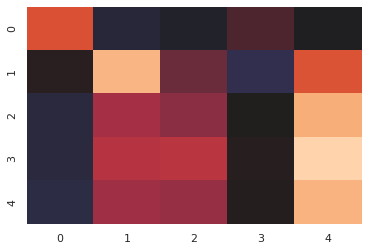

In [1154]:
models = ['speed', 'hd', 'border', 'grid', 'pos']
model_metric1 = 'r2'
model_metric2 = 'coef'
split = 'train'
unit_type = 'cell'
CC = np.zeros((5,5))

for ii, model1 in enumerate(models):
    y_subset =[(model_scores['model']==model1) & 
                (model_scores['metric']==model_metric1) & 
                (model_scores['split']==split) &
                (model_scores['unit_type']==unit_type) &
                (model_scores['session_valid'])][0]

    for jj, model2 in enumerate(models):
        x_subset =[ (model_scores['model']==model2) & 
                    (model_scores['metric']==model_metric2) & 
                    (model_scores['split']==split) &
                    (model_scores['unit_type']==unit_type) &
                    (model_scores['session_valid'])][0]
        CC[ii,jj] = rs.spearman(model_scores.loc[y_subset, 'value'], model_scores.loc[x_subset, 'value'])

sns.heatmap(CC, center=0, cbar=False)

In [935]:
f.savefig(fig5_path/(f'ModelvMetric_{unit_type}_{model_metric}_{split}.pdf'), bbox_inches='tight')

## Example Model Fits

In [997]:
@interact(model=['speed','hd','border','grid', 'pos'], thr=widgets.FloatSlider(min=-1, max=1, step=0.02), unit_type=['cell', 'mua', None], model_metric=['r2', 'map_r', 'coef','n_err'], split=['train', 'test'] )
def model_filter_units(model, thr, model_metric, split, unit_type=None):
    if unit_type is None:
        sub_table = model_scores.loc[ (model_scores.model==model)
                                      & (model_scores.metric==model_metric)
                                      & (model_scores.split==split) 
                                      & (model_scores.value>=thr) 
                                      & (model_scores.session_valid)]
    else:
        sub_table = model_scores.loc[ (model_scores.unit_type==unit_type) 
                                      & (model_scores.model==model)
                                      & (model_scores.metric==model_metric)
                                      & (model_scores.split==split) 
                                      & (model_scores.value>=thr) 
                                      & (model_scores.session_valid)]

    return sub_table.sort_values(by=['value'], ascending=False)

interactive(children=(Dropdown(description='model', options=('speed', 'hd', 'border', 'grid', 'pos'), value='s…

In [434]:
model_metric='coef'
thr = 0.1
tbl = model_scores.groupby(['session','unit_id','metric'], as_index=False).mean()
tbl = tbl[tbl.metric==model_metric ].sort_values(by=['value'], ascending=False)
tbl[tbl.session_valid][10:30]

session  unit_id metric  session_unit_id  session_pct_cov  \
856   Cl_OF_010719     1776   coef                5             0.95   
736   Cl_OF_010418     1074   coef                8             0.95   
704   Cl_OF_010418     1066   coef                0             0.95   
6524  Li_OF_062718      462   coef                9             0.93   
4692  Li_OF_052818        4   coef                4             0.96   
8244  NE_OF_061218      860   coef               21             0.98   
4900  Li_OF_053018       56   coef               13             0.95   
3624  Cl_OF_120918     1500   coef                7             0.86   
7172  Li_OF_080118      624   coef               12             0.97   
3488  Cl_OF_120718     1466   coef                3             0.92   
6248  Li_OF_062018      393   coef               14             0.98   
5376  Li_OF_060518      175   coef               28             0.95   
5048  Li_OF_053118       93   coef               10             0.95   
7456  Mi_OF_021020     2202   coef                0             0.93   
6776  Li_OF_062918      525   coef               17             0.90   
6664  Li_OF_062818      497   coef               12             0.98   
6640  Li_OF_062818      491   coef                6             0.98   
8852  NE_OF_080118     1013   coef                0             0.96   
5144  Li_OF_060118      117   coef               11             0.93   
6672  Li_OF_062818      499   coef               14             0.98   

      session_valid  tt  tt_cl     value  
856            True   2     17  4.901109  
736            True   3     13  4.779356  
704            True   3     27  4.773722  
6524           True  10      0  4.718184  
4692           True   7      1  4.703640  
8244           True   7      9  4.608585  
4900           True   7      6  4.573708  
3624           True  12      4  4.520286  
7172           True   9     15  4.475870  
3488           True  12      0  4.454202  
6248           True   7      4  4.442660  
5376           True  14     15  4.411586  
5048           True   7      7  4.348834  
7456           True  12      8  4.299348  
6776           True  10      0  4.297553  
6664           True  10      0  4.283026  
6640           True   8     21  4.114814  
8852           True  11     11  4.082123  
5144           True   7     25  4.049395  
6672           True  10      4  3.937163

In [998]:
uuid = 113
model_scores[model_scores.unit_id==uuid].groupby(['model', 'metric']).mean()

unit_id  session_unit_id  session_pct_cov  session_valid  tt  \
model  metric                                                                 
border coef        113                7             0.93           True  10   
       map_r       113                7             0.93           True  10   
       n_err       113                7             0.93           True  10   
       r2          113                7             0.93           True  10   
grid   coef        113                7             0.93           True  10   
       map_r       113                7             0.93           True  10   
       n_err       113                7             0.93           True  10   
       r2          113                7             0.93           True  10   
hd     coef        113                7             0.93           True  10   
       map_r       113                7             0.93           True  10   
       n_err       113                7             0.93           True  10   
       r2          113                7             0.93           True  10   
pos    coef        113                7             0.93           True  10   
       map_r       113                7             0.93           True  10   
       n_err       113                7             0.93           True  10   
       r2          113                7             0.93           True  10   
speed  coef        113                7             0.93           True  10   
       map_r       113                7             0.93           True  10   
       n_err       113                7             0.93           True  10   
       r2          113                7             0.93           True  10   

               tt_cl     value  
model  metric                   
border coef        9  3.530457  
       map_r       9  0.521045  
       n_err       9  2.667880  
       r2          9  0.074080  
grid   coef        9  1.366179  
       map_r       9  0.907300  
       n_err       9  2.442985  
       r2          9  0.237400  
hd     coef        9  0.872690  
       map_r       9  0.378632  
       n_err       9  2.733956  
       r2          9  0.012702  
pos    coef        9  0.906137  
       map_r       9  0.893960  
       n_err       9  2.421168  
       r2          9  0.237505  
speed  coef        9 -0.655789  
       map_r       9  0.300246  
       n_err       9  2.752895  
       r2          9 -0.000958

In [999]:
subject, session, suid = model_scores.loc[model_scores.unit_id==uuid, ['subject','session','session_unit_id']].iloc[0]

In [1366]:
from TreeMazeAnalyses2.Analyses import subject_info as si
si = reload(si)
#subject = 'Li'
#session = 'Li_OF_061318'
session_info = si.SubjectSessionInfo(subject, session)

In [900]:
#sem=session_info.get_encoding_models()

Getting Encoding Models
speed model completed. 11.78secs
hd model completed. 10.82secs
ha model completed. 11.15secs
border model completed. 6.05secs


/home/alexgonzalez/Documents/TreeMazeAnalyses2/Analyses/spatial_functions.py:3138: RuntimeWarning: invalid value encountered in true_divide
  def get_grid_encodign_features(fields, x, y, x_bin_edges, y_bin_edges):
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Analyses/spatial_functions.py:3138: RuntimeWarning: invalid value encountered in true_divide
  def get_grid_encodign_features(fields, x, y, x_bin_edges, y_bin_edges):
/home/alexgonzalez/Documents/TreeMazeAnalyses2/Analyses/spatial_functions.py:786: RuntimeWarning: divide by zero encountered in double_scalars
  df = pd.DataFrame(index=range(n_idx), columns=['fold', 'unit_id', 'metric', 'split', 'value'])


grid model completed. 81.60secs
pos model completed. 50.32secs


In [1367]:
behav = session_info.get_track_data()
x, y, speed = behav['x'], behav['y'], behav['sp']
ha, hd = behav['ha'], behav['hd']
fr = session_info.get_fr()
spks = session_info.get_binned_spikes()

params = session_info.task_params

spatial_funcs = reload(spatial_funcs)
#f = spatial_funcs.get_spatial_map_function('fr', **params)

In [1368]:
%%time
spatial_funcs = reload(spatial_funcs)
sem = spatial_funcs.AllSpatialEncodingModels(x,y,speed,ha,hd,neural_data=fr, **params)
scores = sem.get_all_models()

speed model completed. 3.74secs
hd model completed. 3.27secs
ha model completed. 3.36secs
border model completed. 2.01secs
grid model completed. 26.28secs
pos model completed. 12.54secs
CPU times: user 3min 11s, sys: 3min 14s, total: 6min 26s
Wall time: 51.2 s


In [1003]:
mpl.rcParams['lines.solid_capstyle'] = 'round'
mpl.rcParams['lines.dash_capstyle'] = 'round'

def colorline2(
    x, y, z=None, colors=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0,ax=None):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    if colors is None:
        lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha,zorder=1)
    else:
        lc = mcoll.LineCollection(segments, colors=colors,
                              linewidth=linewidth, alpha=alpha,zorder=1)
    if ax is None:
        ax = plt.gca()
    ax.add_collection(lc)

    return lc


@interact(unit=np.arange(session_info.n_units), i=widgets.IntSlider(max=10000,step=500), fold=widgets.IntSlider(min=0,max=4), wl=widgets.IntSlider(value=500,step=500,max=1000)) 
def plot_trace_segment(unit=0, i=0, wl=500, fold=0):
    f,ax = plt.subplots(figsize=(4,4))
    
    samps = np.arange(sem.n_samples)
    test_bool_ids = sem.crossval_samp_ids==fold
    test_samps = samps[test_bool_ids]
    
    window = np.arange(wl) + i
    
    ax.plot(x,y, linewidth=0.2, color='0.5',zorder=-1)

    cmap='rainbow'
    colors = plt.cm.get_cmap(cmap)(np.arange(wl)/wl)
    xx, yy = sem.pos_model.x_pos[test_bool_ids], sem.pos_model.y_pos[test_bool_ids]
    ss = sem.pos_model.get_response_fold(fold)[1][unit]

    colorline2( xx[window] , yy[window], colors=colors, linewidth=7, ax=ax)
    
    #ax.plot(x[window],y[window], '0.2')
    ax.scatter(xx[window],yy[window],s=ss[window]*0.5,  color='0.2' , alpha=0.5)
    ax.scatter(xx[window][0], yy[window][0], s=75, color=colors[0] ,marker='d',zorder=10)
    ax.scatter(xx[window][-1], yy[window][-1], s=75, color=colors[-1], marker='s', zorder=10)
    ax.axis("off")
    ax.set_rasterized(False)

#f.savefig(p/"trace_w.pdf",dpi=300, bbox_inches='tight', pad_inches=0.2)


interactive(children=(Dropdown(description='unit', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

In [1370]:
suid=7

fold=3
i=2000
wl=1000
window = np.arange(wl) + i

samples = np.arange(sem.n_samples)
fold_test_ids_bool = sem.crossval_samp_ids==fold
sp_valid_ids_bool = sem.valid_sp_samps

fold_test_samples = samples[fold_test_ids_bool]
fold_test_window_samples = fold_test_samples[window]

fold_test_samples_sp = samples[fold_test_ids_bool & sp_valid_ids_bool]
fold_test_window_samples_sp = np.intersect1d(fold_test_samples_sp,fold_test_window_samples)

within_fold_samples = np.arange(len(fold_test_samples))
within_fold_window_samples = window

within_fold_samples_sp = np.arange(len(fold_test_samples_sp))
within_fold_window_samples_sp = window[np.in1d(fold_test_window_samples, fold_test_window_samples_sp)]


In [1371]:

models = ['true', 'sp', 'hd', 'pos', 'grid', 'border']
resp = {}

resp['true'] = sem.pos_model.get_response_fold(fold)[1][suid, within_fold_window_samples]

resp['sp'] = sem.speed_model.predict_model_fold(fold)[1][suid, within_fold_window_samples_sp]
resp['hd']= sem.hd_model.predict_model_fold(fold)[1][suid, within_fold_window_samples_sp]

resp['pos'] = sem.pos_model.predict_model_fold(fold)[1][suid, within_fold_window_samples]
resp['grid'] = sem.grid_model.predict_model_fold(fold)[1][suid, within_fold_window_samples]
resp['border'] = sem.border_model.predict_model_fold(fold)[1][suid, within_fold_window_samples]

sm = {}
for m in models:
    resp[m] = resp[m]/resp[m].max()
    if m in ['sp', 'hd']:
        x_win = sem.x[fold_test_window_samples_sp]
        y_win = sem.y[fold_test_window_samples_sp]
    else:
        x_win = sem.x[fold_test_window_samples]
        y_win = sem.y[fold_test_window_samples]
    
    sm[m] = sem.spatial_map_function(resp[m],x_win,y_win)
    
        

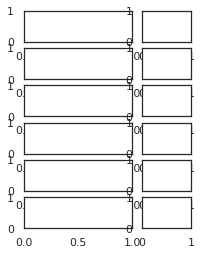

In [1010]:
f = plt.figure(figsize=(3,4))

gs = f.add_gridspec(6,3)
ax = [[]]*12
for ii in range(6):
    ax[ii*2] = f.add_subplot(gs[ii, :2])
    ax[ii*2+1] = f.add_subplot(gs[ii, 2])

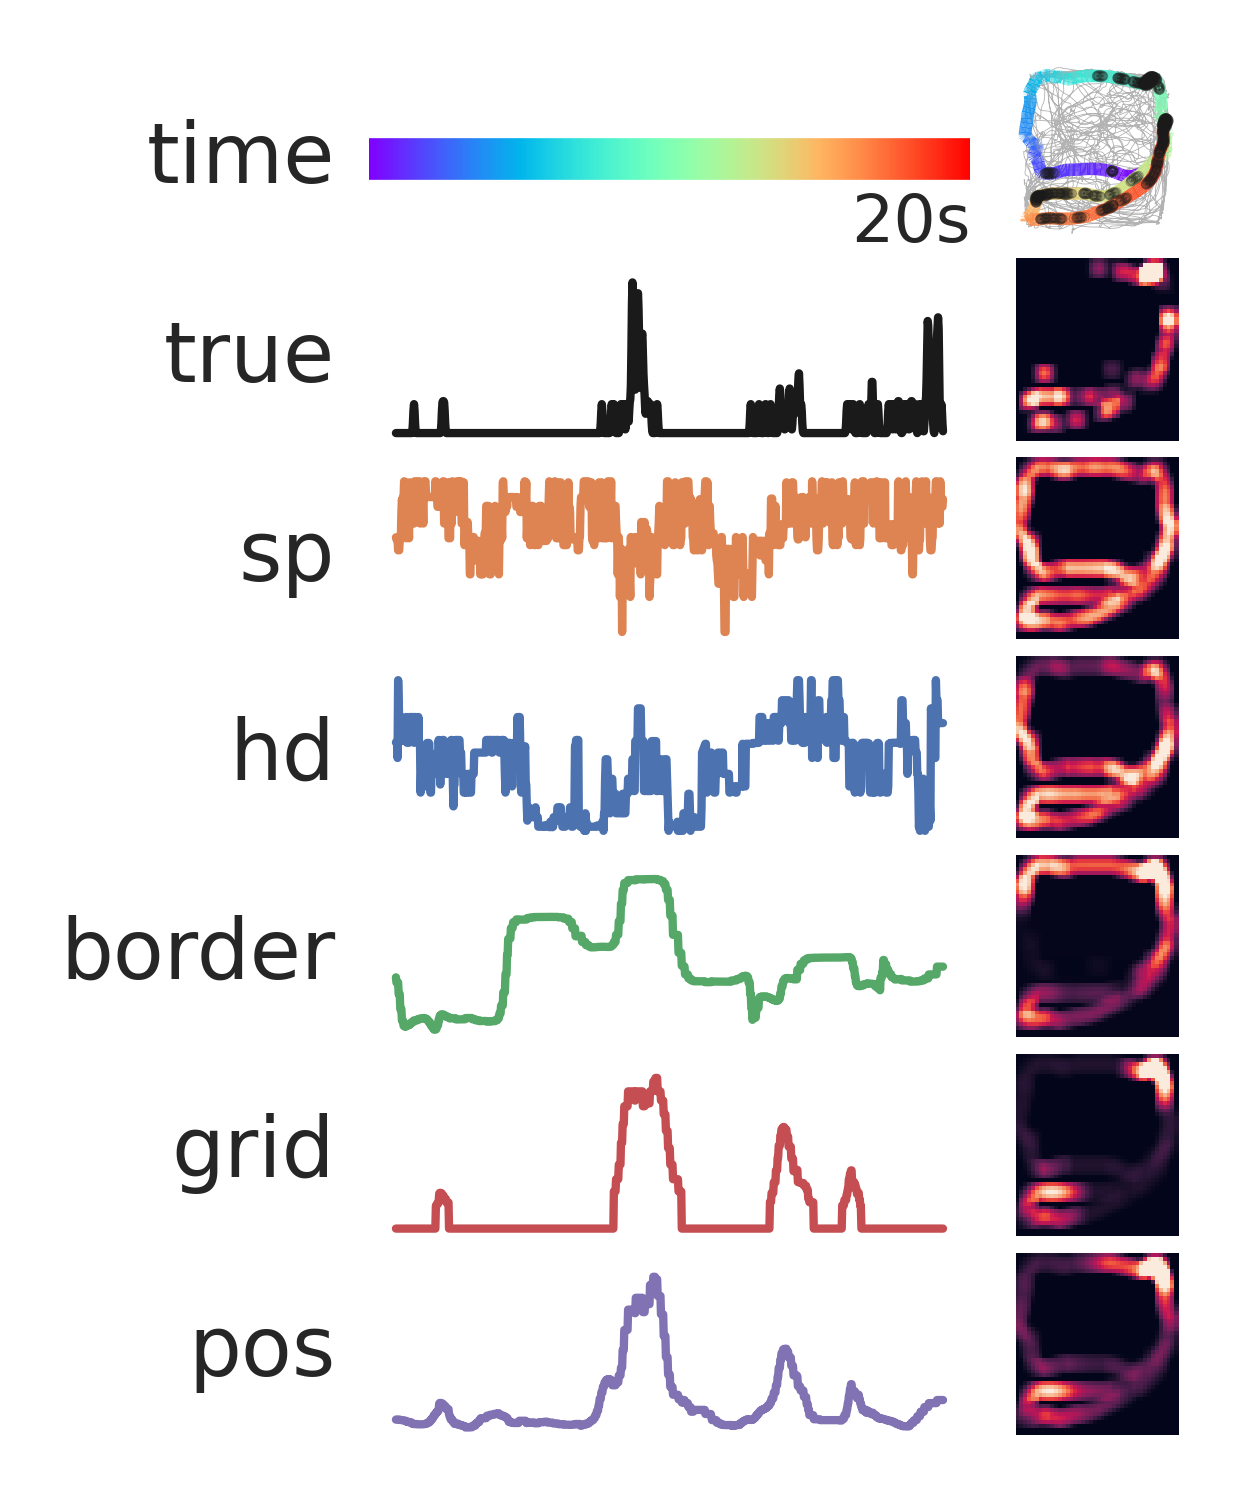

In [1372]:
label_fontsize= 10
tick_fontsize=8

models = ['true', 'sp','hd', 'border', 'grid', 'pos']
sns.set_style('white')
analyses_colors = sns.color_palette(palette='deep', as_cmap=True)
type_color = {'true': 'k',
              'hd': analyses_colors[0],
              'sp': analyses_colors[1],
              'border': analyses_colors[2],
              'grid': analyses_colors[3],
              'pos': analyses_colors[4]}
cmap='rainbow'
colors = plt.cm.get_cmap(cmap)(np.arange(wl)/wl)

f = plt.figure(figsize=(2,3), dpi=600)

gs = f.add_gridspec(7,3,)
ax = [[]]*14
for ii in range(7):
    jj = ii*2
    ax[jj] = f.add_subplot(gs[ii, :2])
    ax[jj+1] = f.add_subplot(gs[ii, 2])
    
colorline(np.linspace(0,1,wl), np.ones(wl) ,colors=colors,linewidth=5, ax=ax[0])
ax[0].set_ylim([0.8,1.2])
#ax[0].text(0,0.8, "t=0s",fontsize=label_fontsize, ha='center')
ax[0].text(1,0.8, f"{wl*0.02:0.0f}s", fontsize=tick_fontsize, ha='right')
for pos in ['left', 'top', 'right', 'bottom']:
        ax[0].spines[pos].set_visible(False)
ax[0].set_yticks([])
ax[0].set_yticklabels('')
ax[0].set_xticks([])
ax[0].set_xticklabels('')
ax[0].set_ylabel('time', fontsize=label_fontsize, va='center', ha='right',  rotation=0)


x_win = sem.x[fold_test_window_samples]
y_win = sem.y[fold_test_window_samples]    

colorline( x_win , y_win, colors=colors, linewidth=1.5, ax=ax[1], alpha=1)
ax[1].plot(x,y, linewidth=0.1, color='0.7',zorder=-1)
ax[1].scatter(x_win, y_win,s=resp['true'],  color='0.1' , alpha=0.3)
ax[1].axis("off")
ax[1].set_rasterized(True)
ax[1].set_aspect('equal', 'box')
p = ax[1].get_position()
ax[1].set_position([p.x0-0.06, p.y0, p.width*1.1, p.height*1.1])

for ii,model in enumerate(models):
    jj = ii*2+3
    sns.heatmap(sm[model],ax=ax[jj],cbar=False,square=True, robust=True)
    ax[jj].axis('off')
    ax[jj].invert_yaxis()
    ax[jj].set_rasterized(True)
    
    p = ax[jj].get_position()
    ax[jj].set_position([p.x0-0.06, p.y0, p.width*1.1, p.height*1.1])
    
t = behav['t']
for ii,model in enumerate(models):
    jj = ii*2+2
    if model in ['sp','hd']:
        tw = t[fold_test_window_samples_sp]
    else:
        tw = t[fold_test_window_samples]

    ax[jj].plot(tw, resp[model], linewidth=1, color=type_color[model])
    ax[jj].set_yticks([])
    ax[jj].set_yticklabels('')
    ax[jj].set_xticklabels('')
    for pos in ['left', 'top', 'right', 'bottom']:
        ax[jj].spines[pos].set_visible(False)
    ax[jj].set_ylabel(model, fontsize=label_fontsize, rotation=0, ha='right', va='center')
    
#ax[12].set_xlabel(' fr [spks/s] ')
f.savefig(fig5_path/(f'ExampleModelsFits{uuid}_i{i}_fold{fold}.pdf'), bbox_inches='tight', dpi=600)

In [1061]:
[p.x0, p.y0, p.width, p.height]

[0.7248695537021113,
 0.7879268292682927,
 0.12231971612518944,
 0.09207317073170729]

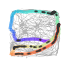

In [1041]:
f, ax=plt.subplots(1,1,figsize=(1,1))

cmap='rainbow'
colors = plt.cm.get_cmap(cmap)(np.arange(wl)/wl)

x_win = sem.x[fold_test_window_samples]
y_win = sem.y[fold_test_window_samples]    

colorline( x_win , y_win, colors=colors, linewidth=3, ax=ax)

#ax.plot(x[window],y[window], '0.2')
ax.plot(x,y, linewidth=0.2, color='0.7',zorder=-1)
ax.scatter(x_win, y_win,s=resp['true']*5,  color='0.2' , alpha=0.5)
#ax.scatter(x_win[0], y_win[0], s=75, color=colors[0] ,marker='d',zorder=10)
#ax.scatter(x_win[-1], y_win[-1], s=75, color=colors[-1], marker='s', zorder=10)
# colorline( x[test_window_smaps] , y[test_window_smaps],colors=colors,linewidth=5, ax=ax[0])

# #ax.plot(x[window],y[window], '0.2')
# ax[0].scatter(x[test_window_smaps],y[test_window_smaps],s=spks[suid,test_window_smaps]*10,  color='0.2' , alpha=0.5)
# ax[0].scatter(x[test_window_smaps][0], y[test_window_smaps][0], s=75, color=colors[0] ,marker='d',zorder=10)
# ax[0].scatter(x[test_window_smaps][-1], y[test_window_smaps][-1], s=75, color=colors[-1], marker='s', zorder=10)
ax.axis("off")
ax.set_rasterized(True)
f.savefig(fig5_path/(f'ExampleModelsFitTrace{uuid}_i{i}_fold{fold}.pdf'), bbox_inches='tight', dpi=500)

## Vennn Diagram for Overlap between task and open field identification of units.

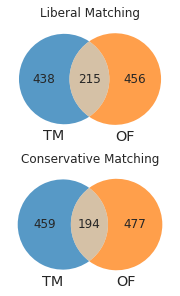

In [466]:
n_TM_cells = unit_table[(unit_table.unit_type=='cell') & (unit_table.task2=='T3')].shape[0]
n_OF_cells = unit_table[(unit_table.unit_type=='cell') & (unit_table.task2=='OF')].shape[0]

n_matches_lib = unit_table.match_lib_multi_task_id.max()+1 
n_matches_con = unit_table.match_con_multi_task_id.max()+1

f, ax = plt.subplots(2,1,constrained_layout=True)
venn2( (n_TM_cells-n_matches_lib, n_OF_cells-n_matches_lib, n_matches_lib), set_labels=['TM', 'OF'], set_colors=colors[:2], alpha=0.75, ax=ax[0])
venn2( (n_TM_cells-n_matches_con, n_OF_cells-n_matches_con, n_matches_con), set_labels=['TM', 'OF'], set_colors=colors[:2], alpha=0.75, ax=ax[1])
ax[0].set_title("Liberal Matching")
ax[1].set_title("Conservative Matching")
f.savefig(fig5_path/(f'ClusterMatchesXTasks.pdf'), bbox_inches='tight')